# 1. モジュールインポート

In [1]:
import pandas as pd
import glob
import os
import datetime
from tqdm.auto import tqdm
from modules.constants import Master
from modules.constants import LocalPaths
from modules.constants import HorseResultsCols
from modules.constants import ResultsCols
from modules import preparing
from modules import preprocessing
from modules import training
from modules import simulation
from modules import policies
%load_ext autoreload

標準的な土日競馬開催時の運用スケジュールを以下の表の通り。

|曜日|時刻|内容|実行する main.ipynb の項番|備考|
|:-:|:--|:--|:--|:--|
|月|||||
|火|||||
|水|16:30過ぎ|先週土日の馬の過去成績ページ確定<BR>（netkeiba.comﾌﾟﾚﾐｱｻｰﾋﾞｽのﾀｲﾑ指数・ﾚｰｽ分析・注目馬 ﾚｰｽ後の短評情報確定）|2. データ取得 ～ 5. シミュレーション|3日間開催の場合も、水曜日|
|木|||||
|金|10:05過ぎ<BR>19:25過ぎ|土曜の出馬表確定<BR>土曜の天候・馬場状態更新|6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|土|09:00～17:00<BR>10:05過ぎ<BR>19:25過ぎ| レース時刻<BR>日曜の出馬表確定<BR>日曜の天候・馬場状態更新|6.3. レース直前データ処理（当日レース予想）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|日|09:00～17:00|レース時刻|6.3. レース直前データ処理（当日レース予想）||

# 2. データ取得

## 2.1. レースID取得
例として、2020年のレースデータを取得する場合を考える

In [2]:
%autoreload

In [3]:
#開催日取得。to_の月は含まないので注意。
kaisai_date_2025 = preparing.scrape_kaisai_date(from_="2023-01-01", to_="2025-10-01")
len(kaisai_date_2025)

getting race date from 2023-01-01 to 2025-10-01


c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preparing\_scrape_race_id_list.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=from_, end=to_, freq="M")


  0%|          | 0/33 [00:00<?, ?it/s]

293

In [4]:
# 開催日からレースIDの取得
race_id_list = preparing.scrape_race_id_list(kaisai_date_2025)
len(race_id_list)

getting race_id_list


  0%|          | 0/293 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230105
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230107
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230107
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230108
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230108
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230109
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230109
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230114
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230114
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230115
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230115
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230121
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230121
scraping: ht

9478

## 2.2. /race/ディレクトリのデータ取得

In [5]:
#https://db.netkeiba.com/race/のhtml(binファイル)をスクレイピングして保存
html_files_race = preparing.scrape_html_race(race_id_list, skip=True)
html_files_race[:5]

  0%|          | 0/9478 [00:00<?, ?it/s]

race_id 202306010101 skipped
race_id 202306010102 skipped
race_id 202306010103 skipped
race_id 202306010104 skipped
race_id 202306010105 skipped
race_id 202306010106 skipped
race_id 202306010107 skipped
race_id 202306010108 skipped
race_id 202306010109 skipped
race_id 202306010110 skipped
race_id 202306010111 skipped
race_id 202306010112 skipped
race_id 202307010101 skipped
race_id 202307010102 skipped
race_id 202307010103 skipped
race_id 202307010104 skipped
race_id 202307010105 skipped
race_id 202307010106 skipped
race_id 202307010107 skipped
race_id 202307010108 skipped
race_id 202307010109 skipped
race_id 202307010110 skipped
race_id 202307010111 skipped
race_id 202307010112 skipped
race_id 202306010201 skipped
race_id 202306010202 skipped
race_id 202306010203 skipped
race_id 202306010204 skipped
race_id 202306010205 skipped
race_id 202306010206 skipped
race_id 202306010207 skipped
race_id 202306010208 skipped
race_id 202306010209 skipped
race_id 202306010210 skipped
race_id 202306

[]

In [6]:
# data/html/race/に保存されているhtml(binファイル)をリストにする
import glob
import os

# LocalPathsからHTMLレースディレクトリを取得
race_html_dir = LocalPaths.HTML_RACE_DIR
print(f"レースHTMLディレクトリ: {race_html_dir}")

# globでbinファイルを検索
html_files_race = glob.glob(os.path.join(race_html_dir, "*.bin"))
print(f"見つかったHTMLファイル数: {len(html_files_race)}")

# 最初の5ファイルを表示
html_files_race[:5]
html_files_race[:5]

レースHTMLディレクトリ: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race
見つかったHTMLファイル数: 9478
見つかったHTMLファイル数: 9478


['c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\race\\202301010101.bin',
 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\race\\202301010102.bin',
 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\race\\202301010103.bin',
 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\race\\202301010104.bin',
 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\race\\202301010105.bin']

In [ ]:
# 変数確認
print(f"html_files_race変数の状態:")
print(f"  タイプ: {type(html_files_race)}")
print(f"  サイズ: {len(html_files_race)}")
print(f"  範囲: {html_files_race[0].split('\\')[-1]} ～ {html_files_race[-1].split('\\')[-1]}")

# これで次のセルでget_rawdata_results関数を正常に実行できます

In [7]:
results_new = preparing.get_rawdata_results(html_files_race) #レース結果テーブルの作成
race_info_new = preparing.get_rawdata_info(html_files_race) #レース情報テーブルの作成
return_tables_new = preparing.get_rawdata_return(html_files_race) #払戻テーブルの作成

preparing raw results table


  0%|          | 0/9478 [00:00<?, ?it/s]

error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202403020501.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202403020504.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404010604.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404010605.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404010604.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404010605.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404030601.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404030601.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404030701.bin
list index out of range
e

  0%|          | 0/9478 [00:00<?, ?it/s]

preparing raw return table


  0%|          | 0/9478 [00:00<?, ?it/s]

error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202403020501.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202403020504.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404010604.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404010605.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404010604.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404010605.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404030601.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404030701.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202404030704.bin
list index out of range
e

In [8]:
# テーブルの更新。元々のテーブルが存在しない場合は、新たに作成される。
preparing.update_rawdata(filepath=LocalPaths.RAW_RESULTS_PATH, new_df=results_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RACE_INFO_PATH, new_df=race_info_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RETURN_TABLES_PATH, new_df=return_tables_new)

## 2.x. 生成済み raw テーブル確認
`data/raw` に保存された各pickleの基本情報を表示します。存在しない場合はスキップします。

In [ ]:
# data/raw 配下の pickle テーブル概要確認 + null率集計
import os
import pathlib
import pandas as pd
import datetime as dt
from modules.constants import LocalPaths

RAW_DIR = pathlib.Path('data/raw')

if not RAW_DIR.exists():
    print(f'ディレクトリが存在しません: {RAW_DIR.resolve()}')
else:
    pickle_files = sorted(RAW_DIR.glob('*.pickle'))
    if not pickle_files:
        print('pickleファイルが見つかりません。先に取得処理を実行してください。')
    else:
        summaries = []
        null_detail_rows = []  # 列単位 null 率詳細
        for p in pickle_files:
            info = {
                'file': p.name,
                'size_MB': round(p.stat().st_size / 1_000_000, 3)
            }
            try:
                df = pd.read_pickle(p)
                info['rows'] = len(df)
                info['cols'] = df.shape[1]
                info['memory_MB'] = round(df.memory_usage(deep=True).sum() / 1_000_000, 3)
                # 代表的なカラムサンプル（最大5件）
                info['sample_cols'] = ', '.join(list(df.columns[:5]))
                # 日付らしき列から範囲を取得
                date_cols = [c for c in df.columns if 'date' in c.lower()]
                date_range = ''
                for dc in date_cols:
                    try:
                        s = pd.to_datetime(df[dc], errors='coerce')
                        if s.notna().any():
                            date_range = f"{dc}:{s.min().date()}→{s.max().date()}"
                            break
                    except Exception:
                        pass
                info['date_range'] = date_range
                # 全体 null 率（セル全体）
                total_cells = df.shape[0] * (df.shape[1] if df.shape[0] else 0)
                info['overall_null_pct'] = round((df.isna().sum().sum() / total_cells) * 100, 2) if total_cells else 0.0
                # 列ごとの null 率
                col_null_pct = (df.isna().mean() * 100).sort_values(ascending=False)
                # 上位10列を詳細に保存（列が10未満なら全て）
                for col, pct in col_null_pct.head(10).items():
                    null_detail_rows.append({
                        'file': p.name,
                        'column': col,
                        'null_pct': round(pct, 2)
                    })
                # 列単位統計（最大値/平均値/中央値）
                info['max_col_null_pct'] = round(col_null_pct.iloc[0], 2) if not col_null_pct.empty else 0.0
                info['mean_col_null_pct'] = round(col_null_pct.mean(), 2) if not col_null_pct.empty else 0.0
                info['median_col_null_pct'] = round(col_null_pct.median(), 2) if not col_null_pct.empty else 0.0
            except Exception as e:
                info['rows'] = 'ERR'
                info['cols'] = 'ERR'
                info['memory_MB'] = 'ERR'
                info['sample_cols'] = f'load error: {e.__class__.__name__}'
                info['date_range'] = ''
                info['overall_null_pct'] = 'ERR'
                info['max_col_null_pct'] = 'ERR'
                info['mean_col_null_pct'] = 'ERR'
                info['median_col_null_pct'] = 'ERR'
            summaries.append(info)
        summary_df = pd.DataFrame(summaries)
        # 表示順を調整
        summary_cols_order = [
            'file','rows','cols','size_MB','memory_MB','overall_null_pct',
            'max_col_null_pct','mean_col_null_pct','median_col_null_pct',
            'sample_cols','date_range'
        ]
        summary_df = summary_df[summary_cols_order]
        display(summary_df)

        if null_detail_rows:
            null_detail_df = pd.DataFrame(null_detail_rows)
            # ファイル毎に null の高い列を横持ち要約（pivot）するオプション（必要であれば）
            display(null_detail_df)

        # 主要パスが指すファイルの存在と行数確認（存在しない場合も出力）
        main_paths = {
            'RAW_RESULTS_PATH': getattr(LocalPaths, 'RAW_RESULTS_PATH', None),
            'RAW_RACE_INFO_PATH': getattr(LocalPaths, 'RAW_RACE_INFO_PATH', None),
            'RAW_RETURN_TABLES_PATH': getattr(LocalPaths, 'RAW_RETURN_TABLES_PATH', None),
            'RAW_HORSE_INFO_PATH': getattr(LocalPaths, 'RAW_HORSE_INFO_PATH', None),
            'RAW_HORSE_RESULTS_PATH': getattr(LocalPaths, 'RAW_HORSE_RESULTS_PATH', None),
            'RAW_PEDS_PATH': getattr(LocalPaths, 'RAW_PEDS_PATH', None)
        }
        path_rows = []
        for key, path in main_paths.items():
            if path is None:
                path_rows.append({'name': key, 'path': None, 'exists': False, 'rows': None})
                continue
            exists = os.path.isfile(path)
            rows = None
            if exists:
                try:
                    rows = len(pd.read_pickle(path))
                except Exception:
                    rows = 'ERR'
            path_rows.append({'name': key, 'path': path, 'exists': exists, 'rows': rows})
        display(pd.DataFrame(path_rows))

In [ ]:
# 既存のresultsデータを読み込んでテスト用horse_idリストを取得
results_new = pd.read_pickle(LocalPaths.RAW_RESULTS_PATH)
print(f"results_new loaded: {results_new.shape}")

# 先頭10頭のテスト用リスト作成
horse_id_list = results_new['horse_id'].unique()
horse_id_test_list = horse_id_list[:10]
print(f"テスト用horse_id: {horse_id_test_list}")

## 2.3. /horse/ディレクトリのデータ取得

In [9]:
%autoreload

In [ ]:
# マスターファイルにNaN値が含まれているものだけ再スクレイピングする
import pandas as pd
import os
from modules.constants import LocalPaths

# マスターファイルからNaN値を持つhorse_idを特定
master_files = {
    'horse_id': 'horse_id.csv',
    'jockey_id': 'jockey_id.csv', 
    'trainer_id': 'trainer_id.csv',
    'owner_id': 'owner_id.csv',
    'breeder_id': 'breeder_id.csv'
}

nan_horse_ids = set()
print("=== マスターファイルのNaN値チェック ===")

# horse_info.pickleを読み込み
try:
    horse_info = pd.read_pickle(os.path.join(LocalPaths.RAW_DIR, 'horse_info.pickle'))
    print(f"horse_info.pickle読み込み完了: {len(horse_info)}頭の馬データ")
except Exception as e:
    print(f"horse_info.pickleの読み込みエラー: {e}")
    horse_info = None

# 各マスターファイルをチェック
for master_type, filename in master_files.items():
    filepath = os.path.join(LocalPaths.MASTER_DIR, filename)
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        id_col = df.columns[0]
        
        # NaN値を持つ行を特定
        nan_rows = df[df[id_col].isna()]
        if len(nan_rows) > 0:
            print(f"\n{master_type}: {len(nan_rows)}個のNaN値を発見")
            
            if horse_info is not None:
                if master_type == 'horse_id':
                    # horse_idが直接NaNの場合（これは通常起こらない）
                    print(f"  -> horse_idが直接NaNになっている行: {len(nan_rows)}")
                else:
                    # 他のIDがNaNの馬を特定
                    col_mapping = {
                        'jockey_id': '騎手',
                        'trainer_id': '調教師', 
                        'owner_id': '馬主',
                        'breeder_id': '生産者'
                    }
                    if master_type in col_mapping:
                        target_col = col_mapping[master_type]
                        if target_col in horse_info.columns:
                            # 該当する列がNaNまたは空文字の馬を特定
                            nan_horses = horse_info[
                                (horse_info[target_col].isna()) | 
                                (horse_info[target_col] == '') |
                                (horse_info[target_col] == 'nan')
                            ]
                            for horse_id in nan_horses.index:
                                nan_horse_ids.add(horse_id)
                            print(f"  -> {target_col}がNaN/空の馬: {len(nan_horses)}頭")
                            if len(nan_horses) > 0:
                                print(f"      例: {list(nan_horses.index)[:5]}")
    else:
        print(f"{master_type}: ファイルが存在しません")

print(f"\n=== 再スクレイピング対象の特定結果 ===")
print(f"再スクレイピングが必要な馬ID数: {len(nan_horse_ids)}")

if len(nan_horse_ids) > 0:
    nan_horse_ids_list = sorted(list(nan_horse_ids))
    print(f"対象馬ID例: {nan_horse_ids_list[:10]}{'...' if len(nan_horse_ids_list) > 10 else ''}")
    
    print(f"\n=== 再スクレイピング実行オプション ===")
    print("以下の変数を設定して次のセルで実行してください：")
    print("re_scrape_horses = True  # この行のコメントアウトを外して実行")
    print("target_horse_ids = nan_horse_ids_list  # 対象馬IDリスト")
    
    # 変数を保存（次のセルで使用）
    globals()['nan_horse_ids_list'] = nan_horse_ids_list
    globals()['re_scrape_needed'] = True
else:
    print("再スクレイピングが必要な馬は見つかりませんでした。")
    globals()['re_scrape_needed'] = False

In [ ]:
# horse_id_listのうち先頭10頭の馬のリストを作成し、スクレイピングテストする
horse_id_list = results_new['horse_id'].unique()
horse_id_test_list = horse_id_list[:10]  # 先頭10頭でテスト

print(f"全体の馬数: {len(horse_id_list)}")
print(f"テスト対象の馬数: {len(horse_id_test_list)}")
print(f"テスト対象馬ID: {horse_id_test_list}")

#htmlをスクレイピング
#すでにスクレイピングしてある馬をスキップしたい場合はskip=Trueにする
#すでにスクレイピングしてある馬でも、新たに出走した成績を更新したい場合はskip=Falseにする
html_files_horse = preparing.scrape_html_horse_with_master(
    horse_id_test_list, skip=False
    )

In [10]:
horse_id_list = results_new['horse_id'].unique()
#htmlをスクレイピング
#すでにスクレイピングしてある馬をスキップしたい場合はskip=Trueにする
#すでにスクレイピングしてある馬でも、新たに出走した成績を更新したい場合はskip=Falseにする
html_files_horse = preparing.scrape_html_horse_with_master(
    horse_id_list, skip=True
    )

scraping


  0%|          | 0/19762 [00:00<?, ?it/s]

horse_id 2021101429 skipped
horse_id 2021105872 skipped
horse_id 2021106854 skipped
horse_id 2021105553 skipped
horse_id 2021100648 skipped
horse_id 2021100159 skipped
horse_id 2021100265 skipped
horse_id 2021103762 skipped
horse_id 2020106547 skipped
horse_id 2020100879 skipped
horse_id 2020100391 skipped
horse_id 2020104346 skipped
horse_id 2020102908 skipped
horse_id 2020100551 skipped
horse_id 2020105380 skipped
horse_id 2020104250 skipped
horse_id 2020104087 skipped
horse_id 2020106395 skipped
horse_id 2020107102 skipped
horse_id 2020101946 skipped
horse_id 2020104215 skipped
horse_id 2020103939 skipped
horse_id 2020102347 skipped
horse_id 2020105632 skipped
horse_id 2020103126 skipped
horse_id 2020100863 skipped
horse_id 2020105061 skipped
horse_id 2020101252 skipped
horse_id 2020101681 skipped
horse_id 2020102875 skipped
horse_id 2020105472 skipped
horse_id 2020106970 skipped
horse_id 2020100036 skipped
horse_id 2020101849 skipped
horse_id 2020105354 skipped
horse_id 2020103018 

In [ ]:
#追加で新たにスクレイピングされた数
len(html_files_horse)

In [ ]:
### scrape関数を実行せずに、保存してあるhtmlのパスを取得する場合、以下を実行 ###

target_date = '2025-09-20' #スクレイピングした日付を指定
# マスタの読み込み
update_master = pd.read_csv(
    LocalPaths.MASTER_RAW_HORSE_RESULTS_PATH,
    dtype=object
    )
# target_dateにスクレイピングしたhorse_idに絞り込む
filter = pd.to_datetime(update_master['updated_at']).dt.strftime('%Y-%m-%d') == target_date
horse_id_list = update_master[filter]['horse_id']

# binファイルのパスを取得
html_files_horse = []
for horse_id in tqdm(horse_id_list):
    file = glob.glob(os.path.join(LocalPaths.HTML_HORSE_DIR, horse_id+'*.bin'))[0]
    html_files_horse.append(file)
html_files_horse[:5]

In [ ]:
# マスターファイルにNaN値が含まれているものだけ再スクレイピングする


In [ ]:
# 再スクレイピング実行（上のセルで特定されたNaN馬のみ）
# 実行する場合は下の行のコメントアウトを外してください
# re_scrape_horses = True

if 're_scrape_horses' in locals() and re_scrape_horses and 're_scrape_needed' in globals() and re_scrape_needed:
    print("=== NaN値を持つ馬の再スクレイピング開始 ===")
    print(f"対象馬数: {len(nan_horse_ids_list)}")
    
    # 進捗表示用
    from tqdm import tqdm
    import time
    
    success_count = 0
    failed_ids = []
    
    for i, horse_id in enumerate(tqdm(nan_horse_ids_list, desc="再スクレイピング")):
        try:
            # 馬情報をスクレイピング
            scrape_horse_html(horse_id)
            success_count += 1
            
            # サーバー負荷軽減のため少し待機
            if i % 10 == 0 and i > 0:
                time.sleep(1)
                
        except Exception as e:
            print(f"エラー - 馬ID {horse_id}: {e}")
            failed_ids.append(horse_id)
            continue
    
    print(f"\n=== 再スクレイピング完了 ===")
    print(f"成功: {success_count}頭")
    print(f"失敗: {len(failed_ids)}頭")
    
    if failed_ids:
        print(f"失敗した馬ID: {failed_ids[:10]}{'...' if len(failed_ids) > 10 else ''}")
    
    print("\n再スクレイピング完了後は、該当セクションのデータ処理を再実行してください。")
    
elif 're_scrape_needed' in globals() and not re_scrape_needed:
    print("再スクレイピングが必要な馬は見つかりませんでした。")
    
else:
    print("再スクレイピングを実行するには以下を設定してください：")
    print("1. 上のセルを実行してNaN馬を特定")
    print("2. 're_scrape_horses = True' のコメントアウトを外す")
    print("3. このセルを再実行")

In [ ]:
# 再スクレイピング後のデータ再処理
# 上の再スクレイピングが完了した後に実行してください
# reprocess_data = True  # コメントアウトを外して実行

if 'reprocess_data' in locals() and reprocess_data:
    print("=== 再スクレイピング後のデータ再処理開始 ===")
    
    # 1. 新しくスクレイピングしたHTMLから馬情報を再抽出
    print("1. 馬情報の再抽出...")
    from modules.preprocessing._horse_info_processor import HorseInfoProcessor
    
    # 新しいHTMLファイルのみ処理
    html_files_horse_new = []
    for horse_id in nan_horse_ids_list:
        html_file = os.path.join(LocalPaths.HTML_HORSE_DIR, f"{horse_id}.bin")
        if os.path.exists(html_file):
            html_files_horse_new.append(html_file)
    
    print(f"再処理対象HTMLファイル数: {len(html_files_horse_new)}")
    
    if len(html_files_horse_new) > 0:
        # 馬情報を再処理
        horse_info_processor = HorseInfoProcessor(html_files_horse_new)
        horse_info_new = horse_info_processor.scrape_horse_info()
        
        # 既存の馬情報に新しい情報をマージ
        try:
            horse_info_existing = pd.read_pickle(os.path.join(LocalPaths.RAW_DIR, 'horse_info.pickle'))
            # 新しい情報で既存の情報を更新
            horse_info_updated = horse_info_existing.copy()
            for horse_id in horse_info_new.index:
                horse_info_updated.loc[horse_id] = horse_info_new.loc[horse_id]
            
            # バックアップ作成
            horse_info_existing.to_pickle(os.path.join(LocalPaths.RAW_DIR, 'horse_info.pickle.bak'))
            
            # 更新されたデータを保存
            horse_info_updated.to_pickle(os.path.join(LocalPaths.RAW_DIR, 'horse_info.pickle'))
            
            print(f"馬情報更新完了: {len(horse_info_new)}頭の情報を更新")
            
        except Exception as e:
            print(f"馬情報の更新エラー: {e}")
    
    # 2. マスターファイルの再生成
    print("\n2. マスターファイルの再生成...")
    
    # horse_info.pickleから各種IDを抽出してマスターファイルを更新
    try:
        horse_info_updated = pd.read_pickle(os.path.join(LocalPaths.RAW_DIR, 'horse_info.pickle'))
        
        # 各マスターファイルを更新
        id_columns = {
            'horse_id.csv': ('index', 'horse_id'),  # インデックスがhorse_id
            'jockey_id.csv': ('騎手', 'jockey_id'),
            'trainer_id.csv': ('調教師', 'trainer_id'),
            'owner_id.csv': ('馬主', 'owner_id'),
            'breeder_id.csv': ('生産者', 'breeder_id')
        }
        
        for master_file, (col_name, id_type) in id_columns.items():
            master_path = os.path.join(LocalPaths.MASTER_DIR, master_file)
            
            if col_name == 'index':
                # horse_idの場合
                unique_ids = horse_info_updated.index.dropna().unique()
            else:
                # その他のIDの場合
                if col_name in horse_info_updated.columns:
                    unique_ids = horse_info_updated[col_name].dropna().unique()
                    unique_ids = [str(x) for x in unique_ids if str(x) not in ['nan', 'NaN', '']]
                else:
                    continue
            
            # 既存のマスターファイルを読み込み
            if os.path.exists(master_path):
                existing_master = pd.read_csv(master_path)
                existing_ids = set(existing_master.iloc[:, 0].dropna().astype(str))
            else:
                existing_ids = set()
                existing_master = pd.DataFrame(columns=[id_type, 'encoded_id'])
            
            # 新しいIDを追加
            new_ids = [id for id in unique_ids if str(id) not in existing_ids]
            
            if new_ids:
                # 新しいエンコードIDを生成
                max_encoded = existing_master['encoded_id'].max() if len(existing_master) > 0 else -1
                new_encoded = list(range(max_encoded + 1, max_encoded + 1 + len(new_ids)))
                
                # 新しいエントリを作成
                new_entries = pd.DataFrame({
                    id_type: new_ids,
                    'encoded_id': new_encoded
                })
                
                # マスターファイルを更新
                updated_master = pd.concat([existing_master, new_entries], ignore_index=True)
                updated_master.to_csv(master_path, index=False)
                
                print(f"{master_file}: {len(new_ids)}個の新しいIDを追加")
        
        print("\nマスターファイル再生成完了！")
        print("これで特徴量エンジニアリングを再実行できます。")
        
    except Exception as e:
        print(f"マスターファイル再生成エラー: {e}")
        
else:
    print("データ再処理を実行するには 'reprocess_data = True' を設定してください")

## 再スクレイピング機能の使い方

### 手順:
1. **NaN値検出**: セル24を実行してマスターファイル内のNaN値を特定
2. **再スクレイピング実行**: セル25で `re_scrape_horses = True` のコメントアウトを外して実行
3. **データ再処理**: セル26で `reprocess_data = True` のコメントアウトを外して実行

### 注意事項:
- 再スクレイピングには時間がかかる場合があります
- サーバー負荷軽減のため、適度な間隔で実行されます
- バックアップファイルが自動生成されます

In [11]:
# data/html/horse/に保存されているhtml(binファイル)をリストにする

import glob
import os

horse_html_dir = LocalPaths.HTML_HORSE_DIR
print(f"馬HTMLディレクトリ: {horse_html_dir}")

html_files_horse = glob.glob(os.path.join(horse_html_dir, "*.bin"))
print(f"見つかったHTMLファイル数: {len(html_files_horse)}")

# 最初の5ファイルを表示
html_files_horse[:5]


馬HTMLディレクトリ: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse
見つかったHTMLファイル数: 19856


['c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\horse\\2011106610.bin',
 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\horse\\2012100683.bin',
 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\horse\\2012103532.bin',
 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\horse\\2012104463.bin',
 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\horse\\2012104504.bin']

In [12]:
# 馬の基本情報テーブルの作成（修正済み関数使用）
%autoreload
horse_info_new = preparing.get_rawdata_horse_info(html_files_horse)

preparing raw horse_info table


  0%|          | 0/19856 [00:00<?, ?it/s]

In [ ]:
# get_rawdata_horse_info関数のデバッグ: 1つのHTMLファイルで詳細確認
import pandas as pd
import re
from bs4 import BeautifulSoup
from numpy import nan as NaN

# テスト用に1つのHTMLファイルを選択
test_html_file = html_files_horse[0]
print(f"テスト対象ファイル: {test_html_file}")

# ファイルを読み込み
with open(test_html_file, 'rb') as f:
    html = f.read()

# horse_idを取得
horse_id = re.findall(r'horse\W(\d+)\.bin', test_html_file)[0]
print(f"horse_id: {horse_id}")

# HTMLファイルサイズとデコード確認
print(f"HTMLファイルサイズ: {len(html)} bytes")

# EUC-JPでデコード試行
for enc in ('euc-jp', 'cp932', 'utf-8'):
    try:
        text = html.decode(enc)
        print(f"デコード成功: {enc}")
        break
    except Exception as e:
        print(f"デコード失敗 {enc}: {e}")
        text = html.decode(enc, errors='ignore')
        print(f"エラー無視でデコード: {enc}")
        break

# BeautifulSoupで解析
soup = BeautifulSoup(text, 'lxml')
print(f"BeautifulSoup解析完了")

# プロフィールテーブルの確認
prof_table = (
    soup.select_one('table.db_prof_table[summary*="プロフィール"]')
    or soup.find('table', attrs={'summary': re.compile('プロフィール')})
)

if prof_table:
    print("プロフィールテーブル発見!")
    print(f"テーブルHTML（最初の500文字）: {str(prof_table)[:500]}")
    
    # テーブルを読み込む
    try:
        df = pd.read_html(str(prof_table), flavor='lxml')[0]
        print(f"DataFrame形状: {df.shape}")
        print(f"DataFrame列名: {list(df.columns)}")
        print("DataFrame内容:")
        display(df)
        
        # 2列形式の確認
        if df.shape[1] >= 2:
            df = df.iloc[:, :2]
            df.columns = ['項目', '値']
            df_info = df.set_index('項目').T
            print("転置後:")
            display(df_info)
        else:
            print(f"プロフィール表の列数が想定外: {df.shape[1]}")
            
    except Exception as e:
        print(f"pd.read_htmlエラー: {e}")
else:
    print("プロフィールテーブルが見つかりません")
    # 代替手段: すべてのテーブルを確認
    print("すべてのテーブルを確認:")
    tables = soup.find_all('table')
    for i, table in enumerate(tables):
        attrs = table.attrs
        print(f"テーブル {i+1}: {attrs}")
        if i < 3:  # 最初の3テーブルの内容を確認
            try:
                df_temp = pd.read_html(str(table))[0]
                print(f"  形状: {df_temp.shape}, 列名: {list(df_temp.columns[:3])}")
                if len(df_temp) > 0:
                    print(f"  最初の行: {df_temp.iloc[0].values[:3]}")
            except Exception as e:
                print(f"  読み込みエラー: {e}")

# ID抽出の確認
def extract_id(selector, pattern):
    a = soup.select_one(selector)
    if a and a.has_attr('href'):
        m = re.search(pattern, a['href'])
        if m:
            return m.group(1)
    return NaN

trainer_id = extract_id('a[href^="/trainer/"]', r'/trainer/([^/]+)/')
owner_id   = extract_id('a[href^="/owner/"]',   r'/owner/([^/]+)/')
breeder_id = extract_id('a[href^="/breeder/"]', r'/breeder/([^/]+)/')

print(f"trainer_id: {trainer_id}")
print(f"owner_id: {owner_id}")
print(f"breeder_id: {breeder_id}")

# 関連リンクの確認
trainer_links = soup.select('a[href^="/trainer/"]')
owner_links = soup.select('a[href^="/owner/"]')
breeder_links = soup.select('a[href^="/breeder/"]')

print(f"調教師リンク数: {len(trainer_links)}")
print(f"馬主リンク数: {len(owner_links)}")
print(f"生産者リンク数: {len(breeder_links)}")

if trainer_links:
    print(f"調教師リンク例: {trainer_links[0].get('href')}")
if owner_links:
    print(f"馬主リンク例: {owner_links[0].get('href')}")
if breeder_links:
    print(f"生産者リンク例: {breeder_links[0].get('href')}")

In [ ]:
# エンコーディング問題の詳細調査（chardetなし）
# 手動で各エンコーディングを試行

encodings_to_try = ['utf-8', 'euc-jp', 'cp932', 'shift_jis', 'iso-2022-jp']

successful_encoding = None
for encoding in encodings_to_try:
    try:
        text_decoded = html.decode(encoding)
        print(f"デコード成功: {encoding}")
        
        # BeautifulSoupで解析
        soup_test = BeautifulSoup(text_decoded, 'lxml')
        
        # プロフィールテーブルの検索
        prof_table_test = (
            soup_test.find('table', class_='db_prof_table') or
            soup_test.find('table', attrs={'summary': re.compile('プロフィール')}) or
            soup_test.select_one('table[summary*="プロフィール"]')
        )
        
        if prof_table_test:
            print(f"  → プロフィールテーブル発見！エンコーディング: {encoding}")
            print(f"  → テーブル属性: {prof_table_test.attrs}")
            
            # テーブル内容を確認
            try:
                df_test = pd.read_html(str(prof_table_test))[0]
                print(f"  → DataFrame形状: {df_test.shape}")
                print("  → DataFrame内容:")
                display(df_test)
                
                # 2列形式に変換してみる
                if df_test.shape[1] >= 2:
                    df_test = df_test.iloc[:, :2]
                    df_test.columns = ['項目', '値']
                    df_info_test = df_test.set_index('項目').T
                    print("  → 転置後:")
                    display(df_info_test)
                    
                successful_encoding = encoding
                break
                
            except Exception as e:
                print(f"  → pd.read_htmlエラー: {e}")
        else:
            print(f"  → プロフィールテーブル見つからず")
            
    except UnicodeDecodeError as e:
        print(f"デコード失敗: {encoding} - {str(e)[:100]}")
        continue
    except Exception as e:
        print(f"その他のエラー {encoding}: {e}")
        continue

if successful_encoding:
    print(f"\n成功したエンコーディング: {successful_encoding}")
    
    # 正しいエンコーディングでの最終確認
    text_final = html.decode(successful_encoding)
    soup_final = BeautifulSoup(text_final, 'lxml')
    
    # すべてのテーブルを確認
    tables_final = soup_final.find_all('table')
    print(f"\n全テーブル数: {len(tables_final)}")
    for i, table in enumerate(tables_final):
        attrs = table.attrs
        summary = attrs.get('summary', '')
        class_names = attrs.get('class', [])
        print(f"テーブル {i+1}: class={class_names}, summary='{summary}'")
        
        # プロフィールらしいテーブルを詳しく確認
        if 'db_prof_table' in class_names or 'プロフィール' in summary:
            try:
                df_detail = pd.read_html(str(table))[0]
                print(f"  → 詳細形状: {df_detail.shape}")
                print(f"  → 列名: {list(df_detail.columns)}")
                if len(df_detail) > 0:
                    print(f"  → 最初の行: {df_detail.iloc[0].values}")
            except Exception as e:
                print(f"  → 読み込みエラー: {e}")
                
else:
    print("\nどのエンコーディングでもプロフィールテーブルが見つかりませんでした")
    
    # HTMLの先頭部分を確認
    print(f"\nHTML先頭500文字（バイナリ）:")
    print(html[:500])
    
    # UTF-8での強制解析
    try:
        text_force = html.decode('utf-8', errors='ignore')
        print(f"\nUTF-8強制デコード後の先頭1000文字:")
        print(text_force[:1000])
    except Exception as e:
        print(f"UTF-8強制デコードエラー: {e}")

In [ ]:
# get_rawdata_horse_info関数の修正版を作成・テスト
def get_rawdata_horse_info_fixed(html_path_list: list):
    """
    horseページのhtmlを受け取って、馬の基本情報のDataFrameに変換する関数（修正版）。
    - UTF-8優先でデコード
    - プロフィールテーブルを確実に特定
    - 調教師/馬主/生産者IDを確実に抽出
    """
    print('preparing raw horse_info table (fixed version)')
    out_rows = []

    for html_path in tqdm(html_path_list):
        try:
            with open(html_path, 'rb') as f:
                raw = f.read()

            # 1) エンコーディング優先順位: UTF-8 → EUC-JP → CP932
            text = None
            for encoding in ['utf-8', 'euc-jp', 'cp932']:
                try:
                    text = raw.decode(encoding)
                    break
                except UnicodeDecodeError:
                    continue
            
            if text is None:
                print(f'エンコーディング失敗: {html_path}')
                continue

            soup = BeautifulSoup(text, 'lxml')

            # 2) プロフィールテーブルの確実な特定
            prof_table = (
                soup.find('table', class_='db_prof_table') or
                soup.find('table', attrs={'summary': re.compile('プロフィール')}) or
                soup.select_one('table[summary*="プロフィール"]')
            )
            
            if prof_table is None:
                print(f'プロフィールテーブル見つからず: {html_path}')
                continue

            # 3) テーブルを読み込む（StringIOを使用して警告を回避）
            from io import StringIO
            df = pd.read_html(StringIO(str(prof_table)))[0]
            
            # 左列を項目名、右列を値として転置（1行化）
            if df.shape[1] >= 2:
                df = df.iloc[:, :2]
                df.columns = ['項目', '値']
                df_info = df.set_index('項目').T
            else:
                print(f'プロフィールテーブルの列数が想定外: {html_path}')
                continue

            # 4) 各IDをより確実に抽出
            def extract_id(selector, pattern):
                a = soup.select_one(selector)
                if a and a.has_attr('href'):
                    m = re.search(pattern, a['href'])
                    if m:
                        return m.group(1)
                return NaN

            trainer_id = extract_id('a[href^="/trainer/"]', r'/trainer/([^/]+)/')
            owner_id   = extract_id('a[href^="/owner/"]',   r'/owner/([^/]+)/')
            breeder_id = extract_id('a[href^="/breeder/"]', r'/breeder/([^/]+)/')

            df_info['trainer_id'] = trainer_id
            df_info['owner_id']   = owner_id
            df_info['breeder_id'] = breeder_id

            # 5) インデックスを horse_id に
            horse_id_m = re.search(r'horse\W(\d+)\.bin', html_path)
            if horse_id_m:
                horse_id = horse_id_m.group(1)
                df_info.index = [horse_id]
                out_rows.append(df_info)
            else:
                print(f'horse_id抽出失敗: {html_path}')
                
        except Exception as e:
            print(f'処理エラー {html_path}: {e}')
            continue

    if not out_rows:
        print('処理できたhorse_infoデータがありません')
        return pd.DataFrame()

    horse_info_df = pd.concat(out_rows, axis=0)
    print(f'horse_info処理完了: {horse_info_df.shape}')
    return horse_info_df

# 修正版でテスト実行
horse_info_new_fixed = get_rawdata_horse_info_fixed(html_files_horse)
print(f"\n修正版の結果: {horse_info_new_fixed.shape}")
if len(horse_info_new_fixed) > 0:
    print(f"列名: {list(horse_info_new_fixed.columns[:5])}")
    print(f"最初の数行:")
    display(horse_info_new_fixed.head())

In [13]:
# 馬の基本情報テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_new)

In [14]:
# 馬の過去成績テーブルの作成
horse_results_new = preparing.get_rawdata_horse_results(html_files_horse)

preparing raw horse_results table


  0%|          | 0/19856 [00:00<?, ?it/s]

horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023100091.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023100276.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023100280.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023100287.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023100387.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023100433.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023100387.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023100433.bin
horse_re

In [ ]:
# 結果確認
print(f"horse_results_new shape: {horse_results_new.shape}")
print(f"horse_results_new type: {type(horse_results_new)}")
if len(horse_results_new) > 0:
    print(f"列名: {list(horse_results_new.columns[:5])}")
    print(f"最初の数行:")
    display(horse_results_new.head())

In [ ]:
# 問題診断: 1つのHTMLファイルでpd.read_htmlの動作確認
import pandas as pd
import re
from bs4 import BeautifulSoup

# テスト用に1つのHTMLファイルを選択
test_html_file = html_files_horse[0]
print(f"テスト対象ファイル: {test_html_file}")

# ファイルを読み込み
with open(test_html_file, 'rb') as f:
    html = f.read()

# horse_idを取得
horse_id = re.findall(r'horse\W(\d+)\.bin', test_html_file)[0]
print(f"horse_id: {horse_id}")

# BeautifulSoupで解析
soup = BeautifulSoup(html, "lxml")
print(f"HTMLファイルサイズ: {len(html)} bytes")

# テーブル要素の確認
tables = soup.find_all('table')
print(f"テーブル数: {len(tables)}")

for i, table in enumerate(tables):
    class_names = table.get('class', [])
    print(f"テーブル {i+1}: class={class_names}")

# pd.read_htmlでテーブル読み込みテスト
try:
    dfs = pd.read_html(html)
    print(f"pd.read_htmlで読み込めたテーブル数: {len(dfs)}")
    
    for i, df in enumerate(dfs):
        print(f"DataFrame {i+1}: 形状={df.shape}, 列名={list(df.columns[:3])}")
        if len(df) > 0:
            print(f"  最初の行: {df.iloc[0].values[:3]}")
        print()
        
except Exception as e:
    print(f"pd.read_htmlエラー: {e}")

# 過去成績テーブルの直接確認
race_results_table = soup.find('table', class_='db_h_race_results')
if race_results_table:
    print("過去成績テーブルが見つかりました!")
    rows = race_results_table.find_all('tr')
    print(f"行数: {len(rows)}")
    if len(rows) > 1:  # ヘッダー行を除く
        first_data_row = rows[1]
        cells = first_data_row.find_all(['td', 'th'])
        print(f"最初のデータ行のセル数: {len(cells)}")
        print(f"最初のセルの内容: {cells[0].get_text(strip=True) if cells else 'なし'}")
else:
    print("過去成績テーブルが見つかりませんでした")

In [ ]:
# get_rawdata_horse_resultsの修正版をテスト
import pandas as pd
import re
from tqdm.auto import tqdm

def get_rawdata_horse_results_fixed(html_path_list: list):
    """
    horseページのhtmlを受け取って、馬の過去成績のDataFrameに変換する関数。
    AJAX実装対応版: 過去成績テーブルはインデックス1（2番目）にある
    """
    print('preparing raw horse_results table (fixed version)')
    horse_results = {}
    for html_path in tqdm(html_path_list):
        with open(html_path, 'rb') as f:
            try:
                # 保存してあるbinファイルを読み込む
                html = f.read()

                # AJAX実装では、過去成績テーブルは2番目（インデックス1）
                dfs = pd.read_html(html)
                
                # テーブル数の確認
                if len(dfs) < 2:
                    print(f'horse_results insufficient tables: {len(dfs)} tables in {html_path}')
                    continue
                
                # 過去成績テーブルは2番目（インデックス1）
                df = dfs[1]
                
                # 新馬の競走馬レビューが付いた場合、
                # 列名に0が付与されるため、次のhtmlへ飛ばす
                if df.columns[0] == 0:
                    print('horse_results empty case1 {}'.format(html_path))
                    continue

                horse_id = re.findall(r'horse\W(\d+)\.bin', html_path)[0]

                df.index = [horse_id] * len(df)
                horse_results[horse_id] = df
                print(f'Successfully processed {horse_id}: {df.shape}')

            # 競走データが無い場合（新馬）を飛ばす
            except IndexError:
                print('horse_results empty case2 {}'.format(html_path))
                continue
            except Exception as e:
                print(f'horse_results error in {html_path}: {e}')
                continue

    if not horse_results:
        print("警告: 処理できた過去成績データがありません")
        return pd.DataFrame()

    # pd.DataFrame型にして一つのデータにまとめる
    horse_results_df = pd.concat([horse_results[key] for key in horse_results])

    # 列名に半角スペースがあれば除去する
    horse_results_df = horse_results_df.rename(columns=lambda x: x.replace(' ', ''))

    return horse_results_df

# 修正版でテスト実行
horse_results_new_fixed = get_rawdata_horse_results_fixed(html_files_horse)
print(f"\n修正版の結果: {horse_results_new_fixed.shape}")
if len(horse_results_new_fixed) > 0:
    print(f"列名: {list(horse_results_new_fixed.columns[:5])}")
    print(f"最初の数行:")
    display(horse_results_new_fixed.head())

In [15]:
# テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_new)

In [ ]:
display(horse_info_new)

# 馬の基本情報テーブルの行数を取得
print(f"馬の基本情報テーブルの行数: {len(horse_info_new)}")


In [ ]:
display(horse_results_new)

## 2.4. /ped/ディレクトリのデータ取得

In [16]:
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=True) #htmlをスクレイピング

  0%|          | 0/19762 [00:00<?, ?it/s]

horse_id 2021101429 skipped
horse_id 2021105872 skipped
horse_id 2021106854 skipped
horse_id 2021105553 skipped
horse_id 2021100648 skipped
horse_id 2021100159 skipped
horse_id 2021100265 skipped
horse_id 2021103762 skipped
horse_id 2020106547 skipped
horse_id 2020100879 skipped
horse_id 2020100391 skipped
horse_id 2020104346 skipped
horse_id 2020102908 skipped
horse_id 2020100551 skipped
horse_id 2020105380 skipped
horse_id 2020104250 skipped
horse_id 2020104087 skipped
horse_id 2020106395 skipped
horse_id 2020107102 skipped
horse_id 2020101946 skipped
horse_id 2020104215 skipped
horse_id 2020103939 skipped
horse_id 2020102347 skipped
horse_id 2020105632 skipped
horse_id 2020103126 skipped
horse_id 2020100863 skipped
horse_id 2020105061 skipped
horse_id 2020101252 skipped
horse_id 2020101681 skipped
horse_id 2020102875 skipped
horse_id 2020105472 skipped
horse_id 2020106970 skipped
horse_id 2020100036 skipped
horse_id 2020101849 skipped
horse_id 2020105354 skipped
horse_id 2020103018 

In [ ]:
# === 血統データ完全スクレイピングの実装 ===
import os
from modules.preparing import scrape_html_ped

# 1. 全てのHTMLファイルから完全な馬IDリストを作成
complete_horse_id_list = [os.path.splitext(os.path.basename(f))[0] for f in html_files_horse]
print(f"完全な馬IDリスト作成完了: {len(complete_horse_id_list)}件")

# 2. 既存の血統データを確認
existing_peds_ids = set([os.path.splitext(os.path.basename(f))[0] for f in html_files_peds])
print(f"既存の血統データ: {len(existing_peds_ids)}件")

# 3. 不足している血統データのIDを特定
missing_ped_ids = set(complete_horse_id_list) - existing_peds_ids
missing_ped_ids_list = sorted(list(missing_ped_ids))
print(f"不足している血統データ: {len(missing_ped_ids_list)}件")

# 4. 年代別の不足状況確認
missing_by_year = {}
for horse_id in missing_ped_ids_list:
    year = horse_id[:4] if horse_id[:4].isdigit() else "unknown"
    missing_by_year[year] = missing_by_year.get(year, 0) + 1

print(f"\n年代別の不足血統データ:")
for year in sorted(missing_by_year.keys()):
    print(f"  {year}年: {missing_by_year[year]}件")

print(f"\n=== スクレイピング実行 ===")
print(f"対象馬数: {len(missing_ped_ids_list)}件")
print(f"推定時間: {len(missing_ped_ids_list) * 2 / 60:.1f}分")

# 5. 不足している血統データをスクレイピング実行
# 警告: これは時間がかかる処理です（約163分）
# バッチ処理で実行することを推奨
print("\n血統データスクレイピングを開始...")
new_ped_files = scrape_html_ped(missing_ped_ids_list, skip=False)
print(f"スクレイピング完了: {len(new_ped_files)}件の新しい血統データを取得")

# 6. 結果確認
import glob
updated_html_files_peds = glob.glob(os.path.join(LocalPaths.HTML_PED_DIR, "*.bin"))
print(f"更新後の血統データファイル数: {len(updated_html_files_peds)}")
print(f"馬情報ファイル数: {len(html_files_horse)}")
print(f"差分: {len(html_files_horse) - len(updated_html_files_peds)}")

In [ ]:
# まず少数でテスト（最初の100件）
test_missing_ids = missing_ped_ids_list[:100]
print(f"テスト対象: {len(test_missing_ids)}件")
test_ped_files = scrape_html_ped(test_missing_ids, skip=False)
print(f"テスト完了: {len(test_ped_files)}件")

# 成功を確認後、残りを実行
remaining_ids = missing_ped_ids_list[100:]
remaining_ped_files = scrape_html_ped(remaining_ids, skip=False)

In [ ]:
# 血統データスクレイピングのテスト: 少数の馬でテスト実行
# 先頭5頭の馬IDを使用してテスト
test_horse_ids = horse_id_test_list[:5]  # 最初の5頭でテスト
print(f"テスト対象馬ID: {test_horse_ids}")

%autoreload

In [ ]:
# 血統HTMLファイルのスクレイピングテスト（5頭のみ）
print("血統HTMLファイルのスクレイピングを開始...")
html_files_peds_test = preparing.scrape_html_ped(test_horse_ids, skip=False)
print(f"スクレイピング完了: {len(html_files_peds_test)}件のHTMLファイル")

# 取得されたファイルパスの確認
if html_files_peds_test:
    print("取得されたファイル:")
    for i, file_path in enumerate(html_files_peds_test[:3]):  # 最初の3件表示
        print(f"  {i+1}: {file_path}")
    if len(html_files_peds_test) > 3:
        print(f"  ... 他{len(html_files_peds_test)-3}件")
else:
    print("取得されたHTMLファイルがありません（既存ファイルがスキップされた可能性）")

In [ ]:
# 血統テーブルの作成テスト
print("血統テーブルの作成を開始...")
peds_test = preparing.get_rawdata_peds(html_files_peds_test)

print(f"血統テーブル作成完了: {peds_test.shape}")
if len(peds_test) > 0:
    print(f"列名: {list(peds_test.columns)}")
    print("血統データサンプル:")
    display(peds_test.head())
    
    # 各列のnull値確認
    print("\n各列のnull値の数:")
    print(peds_test.isnull().sum())
else:
    print("血統テーブルが空です。HTMLファイルの構造を確認します。")

In [ ]:
# 血統HTMLファイルの構造解析
import re
from bs4 import BeautifulSoup

# テスト用に1つの血統HTMLファイルを詳しく調べる
test_ped_file = html_files_peds_test[0]
print(f"解析対象ファイル: {test_ped_file}")

# ファイルを読み込み
with open(test_ped_file, 'rb') as f:
    ped_html = f.read()

print(f"HTMLファイルサイズ: {len(ped_html)} bytes")

# エンコーディングテスト
encodings = ['utf-8', 'euc-jp', 'cp932']
ped_text = None
successful_encoding = None

for encoding in encodings:
    try:
        ped_text = ped_html.decode(encoding)
        successful_encoding = encoding
        print(f"デコード成功: {encoding}")
        break
    except UnicodeDecodeError:
        print(f"デコード失敗: {encoding}")
        continue

if ped_text:
    # BeautifulSoupで解析
    ped_soup = BeautifulSoup(ped_text, 'lxml')
    
    # HTMLの基本情報
    title = ped_soup.find('title')
    print(f"ページタイトル: {title.text if title else 'なし'}")
    
    # テーブル要素の確認
    tables = ped_soup.find_all('table')
    print(f"テーブル数: {len(tables)}")
    
    for i, table in enumerate(tables[:5]):  # 最初の5テーブルを確認
        attrs = table.attrs
        class_names = attrs.get('class', [])
        summary = attrs.get('summary', '')
        print(f"テーブル {i+1}: class={class_names}, summary='{summary}'")
        
        # テーブル内容の簡単な確認
        try:
            df_ped = pd.read_html(str(table))[0]
            print(f"  形状: {df_ped.shape}")
            if len(df_ped) > 0 and df_ped.shape[1] > 0:
                print(f"  列名: {list(df_ped.columns[:3])}")
                print(f"  最初の行: {df_ped.iloc[0].values[:3]}")
        except Exception as e:
            print(f"  読み込みエラー: {e}")
        
        # 血統らしいキーワードを含むテーブルかチェック
        table_text = table.get_text()
        if any(keyword in table_text for keyword in ['父', '母', '祖父', '血統']):
            print(f"  → 血統関連テーブルの可能性あり")
    
    # 血統ツリー構造の確認（td要素のクラス名など）
    print("\n血統ツリー関連の要素:")
    bloodline_elements = ped_soup.find_all(['td', 'div'], class_=re.compile(r'(blood|ped|pedigree)', re.I))
    print(f"血統関連要素数: {len(bloodline_elements)}")
    
    if bloodline_elements:
        for elem in bloodline_elements[:3]:
            print(f"  要素: {elem.name}, class: {elem.get('class')}, text: {elem.get_text()[:50]}...")
            
else:
    print("すべてのエンコーディングでデコードに失敗しました")

In [ ]:
# get_rawdata_peds関数の修正版を作成・テスト
def get_rawdata_peds_fixed(html_path_list: list):
    """
    horse/pedページのhtmlを受け取って、血統のDataFrameに変換する関数（修正版）。
    - EUC-JP優先でデコード
    - 血統テーブルを確実に特定
    - 血統horse_idを確実に抽出
    """
    print('preparing raw peds table (fixed version)')
    peds = {}
    
    for html_path in tqdm(html_path_list):
        try:
            with open(html_path, 'rb') as f:
                raw = f.read()

            # 1) エンコーディング優先順位: EUC-JP → UTF-8 → CP932
            text = None
            for encoding in ['euc-jp', 'utf-8', 'cp932']:
                try:
                    text = raw.decode(encoding)
                    break
                except UnicodeDecodeError:
                    continue
            
            if text is None:
                print(f'エンコーディング失敗: {html_path}')
                continue

            # horse_idを取得
            horse_id = re.findall(r'ped\W(\d+)\.bin', html_path)[0]

            # htmlをsoupオブジェクトに変換
            soup = BeautifulSoup(text, "lxml")

            peds_id_list = []

            # 2) 血統データからhorse_idを取得する
            blood_table = soup.find("table", attrs={"summary": "5代血統表"})
            if blood_table is None:
                # 代替検索
                blood_table = soup.find("table", class_="blood_table")
                
            if blood_table is None:
                print(f'血統テーブル見つからず: {html_path}')
                continue

            horse_a_list = blood_table.find_all("a", attrs={"href": re.compile(r"^/horse/\w{10}")})

            for a in horse_a_list:
                # 血統データのhorse_idを抜き出す
                work_peds_id = re.findall(r'/horse/(\w{10})', a["href"])[0]
                peds_id_list.append(work_peds_id)

            peds[horse_id] = peds_id_list
            print(f'血統ID取得成功 {horse_id}: {len(peds_id_list)}個')

        except Exception as e:
            print(f'処理エラー {html_path}: {e}')
            continue

    if not peds:
        print('処理できた血統データがありません')
        return pd.DataFrame()

    # pd.DataFrame型にして一つのデータにまとめて、列名をpeds_0, ..., peds_61にする
    peds_df = pd.DataFrame.from_dict(peds, orient='index').add_prefix('peds_')
    print(f'血統データ処理完了: {peds_df.shape}')
    return peds_df

# 修正版でテスト実行
peds_test_fixed = get_rawdata_peds_fixed(html_files_peds_test)
print(f"\n修正版の結果: {peds_test_fixed.shape}")
if len(peds_test_fixed) > 0:
    print(f"列名サンプル: {list(peds_test_fixed.columns[:10])}")
    print("血統データサンプル:")
    display(peds_test_fixed.head())

In [ ]:
# 血統テーブル内のリンク構造を詳しく調査
test_ped_file = html_files_peds_test[0]

with open(test_ped_file, 'rb') as f:
    raw = f.read()

# EUC-JPでデコード
text = raw.decode('euc-jp')
soup = BeautifulSoup(text, "lxml")

# 血統テーブルを取得
blood_table = soup.find("table", attrs={"summary": "5代血統表"})
if blood_table:
    print("血統テーブル発見!")
    
    # テーブル内のすべてのリンクを確認
    all_links = blood_table.find_all("a")
    print(f"血統テーブル内の全リンク数: {len(all_links)}")
    
    # 最初の10リンクを詳しく確認
    for i, link in enumerate(all_links[:10]):
        href = link.get('href', '')
        text_content = link.get_text()
        print(f"リンク {i+1}: href='{href}', text='{text_content}'")
    
    # horse関連のリンクパターンを確認
    horse_patterns = [
        r"^/horse/\w{10}",  # 現在のパターン
        r"/horse/",         # より広いパターン
        r"horse",           # 最も広いパターン
    ]
    
    for pattern in horse_patterns:
        matches = blood_table.find_all("a", attrs={"href": re.compile(pattern)})
        print(f"パターン '{pattern}' にマッチするリンク数: {len(matches)}")
        if matches:
            for j, match in enumerate(matches[:3]):
                print(f"  例{j+1}: {match.get('href')}")
    
    # 実際のhorse_idの抽出テスト
    print("\n実際のhorse_id抽出テスト:")
    for link in all_links[:5]:
        href = link.get('href', '')
        if '/horse/' in href:
            print(f"リンク: {href}")
            # 異なる抽出パターンをテスト
            patterns = [
                r'/horse/(\w{10})',
                r'/horse/(\w+)',
                r'horse/(\w+)',
            ]
            for p in patterns:
                matches = re.findall(p, href)
                if matches:
                    print(f"  パターン '{p}': {matches}")
else:
    print("血統テーブルが見つかりません")

In [ ]:
# 修正版のhorse_id抽出パターンを作成・テスト
import re

# 正しいパターンで抽出テスト
correct_pattern = r'https://db\.netkeiba\.com/horse/(\w{10})/$'

test_ped_file = html_files_peds_test[0]
with open(test_ped_file, 'rb') as f:
    raw = f.read()

text = raw.decode('euc-jp')
soup = BeautifulSoup(text, "lxml")
blood_table = soup.find("table", attrs={"summary": "5代血統表"})

if blood_table:
    # 馬の詳細ページのみを抽出
    horse_links = blood_table.find_all("a", attrs={"href": re.compile(correct_pattern)})
    print(f"馬の詳細ページリンク数: {len(horse_links)}")
    
    # horse_idを抽出
    horse_ids = []
    for link in horse_links:
        href = link.get('href')
        match = re.search(correct_pattern, href)
        if match:
            horse_id = match.group(1)
            horse_ids.append(horse_id)
            horse_name = link.get_text().strip()
            print(f"  {horse_id}: {horse_name}")
    
    print(f"\n抽出されたhorse_id数: {len(horse_ids)}")
    print(f"ユニークなhorse_id数: {len(set(horse_ids))}")
else:
    print("血統テーブルが見つかりません")

In [ ]:
# 修正版get_rawdata_peds関数を作成・テスト
def get_rawdata_peds_fixed(horse_id_list):
    """
    血統データを取得する修正版関数
    """
    
    peds_new = pd.DataFrame()
    
    for horse_id in tqdm(horse_id_list):
        try:
            # ファイルパスを作成
            html_path = f"data/html/ped/{horse_id}.bin"
            
            # ファイルが存在するかチェック
            if not os.path.exists(html_path):
                print(f"ファイルが見つかりません: {html_path}")
                continue
            
            # HTMLファイルを読み込み
            with open(html_path, 'rb') as f:
                raw = f.read()
            
            # エンコーディングを試行（UTF-8 → EUC-JP → CP932）
            for encoding in ['utf-8', 'euc-jp', 'cp932']:
                try:
                    text = raw.decode(encoding)
                    break
                except UnicodeDecodeError:
                    continue
            else:
                print(f"デコードに失敗しました: {horse_id}")
                continue
            
            # BeautifulSoupでパース
            soup = BeautifulSoup(text, "lxml")
            
            # 血統テーブルを検索
            blood_table = soup.find("table", attrs={"summary": "5代血統表"})
            
            if blood_table is None:
                print(f"血統テーブルが見つかりません: {horse_id}")
                continue
            
            # 修正された正規表現パターンで血統IDを抽出
            pattern = r'https://db\.netkeiba\.com/horse/(\w{10})/$'
            horse_links = blood_table.find_all("a", attrs={"href": re.compile(pattern)})
            
            # horse_idを抽出
            peds_horse_ids = []
            for link in horse_links:
                href = link.get('href')
                match = re.search(pattern, href)
                if match:
                    peds_horse_ids.append(match.group(1))
            
            # 結果をDataFrameに追加
            if peds_horse_ids:
                temp_df = pd.DataFrame({
                    'horse_id': [horse_id] * len(peds_horse_ids),
                    'peds_horse_id': peds_horse_ids
                })
                peds_new = pd.concat([peds_new, temp_df], ignore_index=True)
                print(f"血統ID取得成功 {horse_id}: {len(peds_horse_ids)}個")
            else:
                print(f"血統IDが取得できませんでした: {horse_id}")
                
        except Exception as e:
            print(f"エラーが発生しました {horse_id}: {e}")
            continue
    
    return peds_new

# テスト用の血統HTMLファイルから馬IDを抽出
test_horse_ids = []
for file_path in html_files_peds_test:
    file_name = os.path.basename(file_path)
    horse_id = file_name.replace('.bin', '')
    test_horse_ids.append(horse_id)

print(f"テスト用馬ID: {test_horse_ids}")

# テスト実行
print("修正版get_rawdata_peds関数をテスト中...")
peds_new_fixed = get_rawdata_peds_fixed(test_horse_ids)
print(f"\n修正版関数の結果: {peds_new_fixed.shape}")
print(peds_new_fixed.head(10))

In [ ]:
# モジュールをリロードして修正版をテスト
import importlib
import sys

# モジュールをリロード
if 'modules.preparing._get_rawdata' in sys.modules:
    del sys.modules['modules.preparing._get_rawdata']

from modules.preparing._get_rawdata import get_rawdata_peds

# 修正版の関数でテスト
print("元ファイルの修正版get_rawdata_peds関数をテスト中...")
peds_from_module = get_rawdata_peds(html_files_peds_test)
print(f"\nモジュール関数の結果: {peds_from_module.shape}")
print(peds_from_module.head())

In [ ]:
# 血統データスクレイピングテストの結果確認
print("=== 血統データスクレイピングテスト結果 ===")
print(f"テスト馬数: {len(test_horse_ids)}頭")
print(f"取得血統データ: {peds_from_module.shape[0]}頭 × {peds_from_module.shape[1]}血統ID")
print(f"総血統ID数: {peds_from_module.shape[0] * peds_from_module.shape[1]}個")

# 各馬の血統ID数を確認
print(f"\n各馬の血統ID数:")
for horse_id in test_horse_ids:
    if horse_id in peds_from_module.index:
        non_null_count = peds_from_module.loc[horse_id].notna().sum()
        print(f"  {horse_id}: {non_null_count}個")

# サンプル血統データを表示
print(f"\n血統データサンプル（馬ID: {test_horse_ids[0]}）:")
sample_row = peds_from_module.loc[test_horse_ids[0]]
sample_peds = sample_row.dropna().head(10)
for i, (col, horse_id) in enumerate(sample_peds.items()):
    print(f"  {col}: {horse_id}")

print("\n血統データテーブル作成テスト: ✅ 成功")

In [18]:
import glob
import os

# LocalPathsからHTML血統ディレクトリを取得
ped_html_dir = LocalPaths.HTML_PED_DIR
print(f"血統HTMLディレクトリ: {ped_html_dir}")

# globでbinファイルを検索
html_files_peds = glob.glob(os.path.join(ped_html_dir, "*.bin"))
print(f"見つかったHTMLファイル数: {len(html_files_peds)}")

# 最初の5ファイルを表示
html_files_peds[:5]

血統HTMLディレクトリ: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\ped
見つかったHTMLファイル数: 19856


['c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\ped\\2011106610.bin',
 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\ped\\2012100683.bin',
 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\ped\\2012103532.bin',
 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\ped\\2012104463.bin',
 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\data\\html\\ped\\2012104504.bin']

In [ ]:
# HTML数の詳細分析：馬の基本情報と血統データの差異調査
import os

# 馬の基本情報のIDリストを作成
horse_ids = set([os.path.splitext(os.path.basename(f))[0] for f in html_files_horse])
print(f"馬の基本情報のユニークID数: {len(horse_ids)}")

# 血統データのIDリストを作成
peds_ids = set([os.path.splitext(os.path.basename(f))[0] for f in html_files_peds])
print(f"血統データのユニークID数: {len(peds_ids)}")

print(f"\n数の違い: {len(horse_ids) - len(peds_ids)} 件")

# 血統データがない馬IDを特定
missing_peds = horse_ids - peds_ids
print(f"\n血統データがない馬IDの数: {len(missing_peds)}")

if len(missing_peds) > 0:
    print("\n血統データがない馬IDの例（最初の10件）:")
    missing_list = sorted(list(missing_peds))
    for horse_id in missing_list[:10]:
        print(f"  {horse_id}")
        
    # 年代別の分析
    print("\n年代別の分析（血統データ不足）:")
    year_analysis = {}
    for horse_id in missing_peds:
        year = horse_id[:4]  # 馬IDの最初の4文字が年
        year_analysis[year] = year_analysis.get(year, 0) + 1
    
    for year in sorted(year_analysis.keys()):
        print(f"  {year}年: {year_analysis[year]}件")

# 逆に馬の基本情報がない血統データがあるかも確認
missing_horse_info = peds_ids - horse_ids
print(f"\n馬の基本情報がない血統データの数: {len(missing_horse_info)}")
if len(missing_horse_info) > 0:
    print("馬の基本情報がない血統IDの例（最初の5件）:")
    for ped_id in list(missing_horse_info)[:5]:
        print(f"  {ped_id}")

In [ ]:
# スクレイピングプロセスの差異調査
print("=== スクレイピングプロセス差異分析 ===")

# 1. データ収集時期の違いを確認
print("\n1. 収集データの時期分析:")
horse_years = {}
peds_years = {}

for f in html_files_horse:
    horse_id = os.path.splitext(os.path.basename(f))[0]
    year = horse_id[:4] if horse_id[:4].isdigit() else "unknown"
    horse_years[year] = horse_years.get(year, 0) + 1

for f in html_files_peds:
    ped_id = os.path.splitext(os.path.basename(f))[0]
    year = ped_id[:4] if ped_id[:4].isdigit() else "unknown"
    peds_years[year] = peds_years.get(year, 0) + 1

print("年別収集数の比較:")
all_years = sorted(set(horse_years.keys()) | set(peds_years.keys()))
for year in all_years:
    horse_count = horse_years.get(year, 0)
    peds_count = peds_years.get(year, 0)
    diff = horse_count - peds_count
    print(f"  {year}年: 馬情報{horse_count:5d}件, 血統{peds_count:5d}件, 差分{diff:5d}件")

# 2. ファイルサイズの分析（スクレイピング成功率の推定）
print("\n2. ファイルサイズ分析（サンプル）:")
import random

sample_horse_files = random.sample(html_files_horse, min(50, len(html_files_horse)))
sample_peds_files = random.sample(html_files_peds, min(50, len(html_files_peds)))

horse_sizes = [os.path.getsize(f) for f in sample_horse_files if os.path.exists(f)]
peds_sizes = [os.path.getsize(f) for f in sample_peds_files if os.path.exists(f)]

if horse_sizes and peds_sizes:
    print(f"馬情報ファイル平均サイズ: {sum(horse_sizes)/len(horse_sizes):.0f} bytes")
    print(f"血統ファイル平均サイズ: {sum(peds_sizes)/len(peds_sizes):.0f} bytes")
    print(f"小さすぎるファイル（<1000 bytes）の割合:")
    small_horse = sum(1 for s in horse_sizes if s < 1000) / len(horse_sizes) * 100
    small_peds = sum(1 for s in peds_sizes if s < 1000) / len(peds_sizes) * 100
    print(f"  馬情報: {small_horse:.1f}%")
    print(f"  血統: {small_peds:.1f}%")

In [19]:
peds_new = preparing.get_rawdata_peds(html_files_peds) #血統テーブルの作成
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_new) #テーブルの更新

preparing raw peds table


  0%|          | 0/19856 [00:00<?, ?it/s]

In [ ]:
display(peds_new)

# 3. データ加工

In [17]:
#モジュールを更新した際、notebookに反映させるために使用。
#すでにインポートしてあるモジュールの更新が反映される。
%autoreload

In [18]:
#前処理
results_processor = preprocessing.ResultsProcessor(filepath=LocalPaths.RAW_RESULTS_PATH)
race_info_processor = preprocessing.RaceInfoProcessor(filepath=LocalPaths.RAW_RACE_INFO_PATH)
return_processor = preprocessing.ReturnProcessor(filepath=LocalPaths.RAW_RETURN_TABLES_PATH)
horse_info_processor = preprocessing.HorseInfoProcessor(
    filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = preprocessing.HorseResultsProcessor(
    filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

              着順  枠番  馬番         馬名  性齢    斤量    騎手     タイム     着差     単勝  \
202301010101   1   5   5    サトミノキラリ  牡2  55.0  横山武史  1:09.5    NaN    1.2   
202301010101   2   8   8     ベアゴーゴー  牝2  55.0   浜中俊  1:09.5     クビ    4.1   
202301010101   3   6   6  ハピアーザンエバー  牡2  55.0  藤岡佑介  1:10.0  2.1/2   59.9   
202301010101   4   4   4  デビルシズカチャン  牝2  55.0  ルメール  1:10.2  1.1/2   16.6   
202301010101   5   1   1   ウィスピースノー  牝2  55.0  吉田隼人  1:10.3    1/2   23.9   
...           ..  ..  ..        ...  ..   ...   ...     ...    ...    ...   
202510020812  14   5   9   テーオースパロー  牡6  58.0  吉村誠之  1:08.8     ハナ   71.3   
202510020812  15   3   5  タガノスペルノヴァ  牡7  58.0  川須栄彦  1:08.9    1/2  120.4   
202510020812  16   2   3   サトノプリエール  牝6  56.0  団野大成  1:09.1      1   31.8   
202510020812  17   4   7      インテンソ  セ5  58.0  泉谷楓真  1:09.3  1.1/2  167.9   
202510020812  18   3   6       ガリレイ  セ8  58.0  角田大和  1:09.4    1/2   77.2   

                人気       馬体重       調教師    horse_id jockey_id trainer_id  \


c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_horse_results_processor.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[Cols.PRIZE].fillna(0, inplace=True)


馬の過去成績を集計しつつ、前処理の済みの全てのテーブルをマージする処理

In [19]:
# ターゲットエンコーディング時に「馬の成績」として扱う項目
TARGET_COLS = [
        HorseResultsCols.RANK,
        HorseResultsCols.PRIZE,
        HorseResultsCols.RANK_DIFF, 
        'first_corner',
        'final_corner',
        'first_to_rank',
        'first_to_final',
        'final_to_rank',
        'time_seconds'
        ]
# horse_id列と共に、ターゲットエンコーディングの対象にする列
GROUP_COLS = [
        'course_len',
        'race_type',
        HorseResultsCols.PLACE
        ]

data_merger = preprocessing.DataMerger(
        results_processor,
        race_info_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
)
# 処理実行
data_merger.merge()

separating horse results by date


  0%|          | 0/290 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/290 [00:00<?, ?it/s]

In [20]:
#カテゴリ変数の処理
feature_enginnering = preprocessing.FeatureEngineering(data_merger)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_feature_engineering.py:102: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  new_target_master = pd.concat([target_master, new_target]).set_index(target_col)['encoded_id']
c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_feature_engineering.py:102: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  new_target_master = pd.concat([target_master, new_target]).set_index(target_col)['encoded_id']
c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_feature_enginee

In [24]:
#保存
#tmpは一時保存用のディレクトリ
feature_enginnering.featured_data.to_pickle('data/tmp/featured_data_20250920.pickle')

# 4. 学習

In [25]:
keiba_ai = training.KeibaAIFactory.create(feature_enginnering.featured_data) #モデル作成
keiba_ai.train_with_tuning() #パラメータチューニングをして学習

[I 2025-09-20 21:59:21,984] A new study created in memory with name: no-name-49a0d526-6391-43aa-8c05-a2e7c3344b54
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores don't improve for 10 rounds
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.457763:  14%|#4        | 1/7 [00:01<00:08,  1.47s/it]

[100]	valid_0's binary_logloss: 0.402595	valid_1's binary_logloss: 0.457947
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.403389	valid_1's binary_logloss: 0.457763
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM]

feature_fraction, val_score: 0.457763:  29%|##8       | 2/7 [00:02<00:07,  1.45s/it]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.410603	valid_1's binary_logloss: 0.458168
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

feature_fraction, val_score: 0.457763:  43%|####2     | 3/7 [00:04<00:05,  1.47s/it]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.409393	valid_1's binary_logloss: 0.459147
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

feature_fraction, val_score: 0.457763:  57%|#####7    | 4/7 [00:05<00:04,  1.48s/it]

Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.408866	valid_1's binary_logloss: 0.459534
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

feature_fraction, val_score: 0.457763:  71%|#######1  | 5/7 [00:07<00:02,  1.46s/it]

Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.415166	valid_1's binary_logloss: 0.458743
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

feature_fraction, val_score: 0.457763:  86%|########5 | 6/7 [00:08<00:01,  1.47s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.415576	valid_1's binary_logloss: 0.459092
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

feature_fraction, val_score: 0.457726: 100%|##########| 7/7 [00:10<00:00,  1.47s/it]



[100]	valid_0's binary_logloss: 0.404415	valid_1's binary_logloss: 0.458068
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.389759	valid_1's binary_logloss: 0.457726


num_leaves, val_score: 0.457726:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores don't improve for 10 rounds
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.457726:   5%|5         | 1/20 [00:01<00:31,  1.66s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.342289	valid_1's binary_logloss: 0.463328
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

num_leaves, val_score: 0.457726:  10%|#         | 2/20 [00:03<00:28,  1.57s/it]

Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.372514	valid_1's binary_logloss: 0.460352
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

num_leaves, val_score: 0.457726:  15%|#5        | 3/20 [00:04<00:26,  1.56s/it]

Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.358504	valid_1's binary_logloss: 0.461816
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

num_leaves, val_score: 0.457726:  20%|##        | 4/20 [00:06<00:26,  1.67s/it]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.311052	valid_1's binary_logloss: 0.465461
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

num_leaves, val_score: 0.457726:  25%|##5       | 5/20 [00:08<00:25,  1.72s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.307122	valid_1's binary_logloss: 0.46518
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222


num_leaves, val_score: 0.457726:  30%|###       | 6/20 [00:09<00:21,  1.55s/it]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.467571	valid_1's binary_logloss: 0.475827
[200]	valid_0's binary_logloss: 0.462023	valid_1's binary_logloss: 0.471929
Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 0.462178	valid_1's binary_logloss: 0.471602
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010214 seconds.
You c

num_leaves, val_score: 0.457726:  35%|###5      | 7/20 [00:11<00:20,  1.60s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.322072	valid_1's binary_logloss: 0.464904
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

num_leaves, val_score: 0.457726:  40%|####      | 8/20 [00:12<00:18,  1.50s/it]

Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.43596	valid_1's binary_logloss: 0.458699
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

num_leaves, val_score: 0.457726:  45%|####5     | 9/20 [00:14<00:17,  1.56s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.325065	valid_1's binary_logloss: 0.463831
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

num_leaves, val_score: 0.457726:  50%|#####     | 10/20 [00:15<00:15,  1.53s/it]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.383385	valid_1's binary_logloss: 0.45988
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores 

num_leaves, val_score: 0.457726:  55%|#####5    | 11/20 [00:17<00:14,  1.60s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.312482	valid_1's binary_logloss: 0.464031
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

num_leaves, val_score: 0.457726:  60%|######    | 12/20 [00:19<00:12,  1.61s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.34257	valid_1's binary_logloss: 0.463769
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores 

num_leaves, val_score: 0.457726:  65%|######5   | 13/20 [00:20<00:10,  1.56s/it]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.383385	valid_1's binary_logloss: 0.45988
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores 

num_leaves, val_score: 0.457726:  70%|#######   | 14/20 [00:22<00:09,  1.54s/it]

Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.370226	valid_1's binary_logloss: 0.461572
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

num_leaves, val_score: 0.457726:  75%|#######5  | 15/20 [00:23<00:08,  1.60s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.319115	valid_1's binary_logloss: 0.464115
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

num_leaves, val_score: 0.457726:  80%|########  | 16/20 [00:25<00:06,  1.70s/it]

Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.28924	valid_1's binary_logloss: 0.46566
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores d

num_leaves, val_score: 0.457726:  85%|########5 | 17/20 [00:27<00:05,  1.75s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.301848	valid_1's binary_logloss: 0.465283
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

num_leaves, val_score: 0.457726:  90%|######### | 18/20 [00:29<00:03,  1.66s/it]

[100]	valid_0's binary_logloss: 0.405641	valid_1's binary_logloss: 0.458768
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.402424	valid_1's binary_logloss: 0.458466
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM

num_leaves, val_score: 0.457726:  95%|#########5| 19/20 [00:30<00:01,  1.65s/it]

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.355184	valid_1's binary_logloss: 0.462075
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

num_leaves, val_score: 0.457726: 100%|##########| 20/20 [00:32<00:00,  1.61s/it]


[100]	valid_0's binary_logloss: 0.402973	valid_1's binary_logloss: 0.458898
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.400564	valid_1's binary_logloss: 0.45863


bagging, val_score: 0.457726:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores don't improve for 10 rounds
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.457726:  10%|#         | 1/10 [00:01<00:12,  1.42s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.414662	valid_1's binary_logloss: 0.461506
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

bagging, val_score: 0.457726:  20%|##        | 2/10 [00:02<00:11,  1.43s/it]

Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.4116	valid_1's binary_logloss: 0.459078
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores d

bagging, val_score: 0.457726:  30%|###       | 3/10 [00:04<00:10,  1.46s/it]

[100]	valid_0's binary_logloss: 0.404097	valid_1's binary_logloss: 0.458905
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.399812	valid_1's binary_logloss: 0.45867
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM]

bagging, val_score: 0.457726:  40%|####      | 4/10 [00:05<00:08,  1.42s/it]

[100]	valid_0's binary_logloss: 0.405998	valid_1's binary_logloss: 0.462012
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.409858	valid_1's binary_logloss: 0.461582
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM]

bagging, val_score: 0.457726:  50%|#####     | 5/10 [00:07<00:07,  1.41s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.411209	valid_1's binary_logloss: 0.460403
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

bagging, val_score: 0.457726:  60%|######    | 6/10 [00:08<00:05,  1.42s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.411177	valid_1's binary_logloss: 0.459585
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

bagging, val_score: 0.457726:  70%|#######   | 7/10 [00:09<00:04,  1.42s/it]

[100]	valid_0's binary_logloss: 0.40488	valid_1's binary_logloss: 0.46024
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.404412	valid_1's binary_logloss: 0.46013
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [

bagging, val_score: 0.457726:  80%|########  | 8/10 [00:11<00:02,  1.43s/it]

[100]	valid_0's binary_logloss: 0.40437	valid_1's binary_logloss: 0.458894
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.405694	valid_1's binary_logloss: 0.458732
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] 

bagging, val_score: 0.457726:  90%|######### | 9/10 [00:12<00:01,  1.44s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.40993	valid_1's binary_logloss: 0.458175
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores 

bagging, val_score: 0.457726: 100%|##########| 10/10 [00:14<00:00,  1.43s/it]


Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.414748	valid_1's binary_logloss: 0.459434


feature_fraction_stage2, val_score: 0.457726:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores don't improve for 10 rounds
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.457506:  33%|###3      | 1/3 [00:01<00:02,  1.49s/it]

[100]	valid_0's binary_logloss: 0.403607	valid_1's binary_logloss: 0.457772
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.397421	valid_1's binary_logloss: 0.457506
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM

feature_fraction_stage2, val_score: 0.456849:  67%|######6   | 2/3 [00:02<00:01,  1.46s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.456849
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

feature_fraction_stage2, val_score: 0.456849: 100%|##########| 3/3 [00:04<00:00,  1.46s/it]


[100]	valid_0's binary_logloss: 0.403773	valid_1's binary_logloss: 0.458627
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.407391	valid_1's binary_logloss: 0.45849


regularization_factors, val_score: 0.456849:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores don't improve for 10 rounds
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.456849:   5%|5         | 1/20 [00:01<00:28,  1.49s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.456849
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

regularization_factors, val_score: 0.456849:  10%|#         | 2/20 [00:02<00:26,  1.48s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.45685
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores 

regularization_factors, val_score: 0.456849:  15%|#5        | 3/20 [00:04<00:24,  1.47s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.456849
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

regularization_factors, val_score: 0.456849:  20%|##        | 4/20 [00:05<00:23,  1.49s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.456849
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

regularization_factors, val_score: 0.456849:  25%|##5       | 5/20 [00:07<00:22,  1.48s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.456849
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

regularization_factors, val_score: 0.456849:  30%|###       | 6/20 [00:08<00:20,  1.49s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.456849
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

regularization_factors, val_score: 0.456849:  35%|###5      | 7/20 [00:10<00:19,  1.50s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.45685
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores 

regularization_factors, val_score: 0.456849:  40%|####      | 8/20 [00:11<00:17,  1.49s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.456849
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

regularization_factors, val_score: 0.456849:  45%|####5     | 9/20 [00:13<00:16,  1.48s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.456849
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

regularization_factors, val_score: 0.456849:  50%|#####     | 10/20 [00:14<00:15,  1.51s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.45685
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores 

regularization_factors, val_score: 0.456849:  55%|#####5    | 11/20 [00:16<00:13,  1.50s/it]

Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.411516	valid_1's binary_logloss: 0.458357
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

regularization_factors, val_score: 0.456849:  60%|######    | 12/20 [00:17<00:12,  1.50s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.45685
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores 

regularization_factors, val_score: 0.456849:  65%|######5   | 13/20 [00:19<00:10,  1.52s/it]

Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.41062	valid_1's binary_logloss: 0.457291
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores 

regularization_factors, val_score: 0.456849:  70%|#######   | 14/20 [00:20<00:09,  1.51s/it]

Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.4173	valid_1's binary_logloss: 0.458239
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores d

regularization_factors, val_score: 0.456849:  75%|#######5  | 15/20 [00:22<00:07,  1.51s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.456849
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

regularization_factors, val_score: 0.456849:  80%|########  | 16/20 [00:23<00:06,  1.50s/it]

Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.411516	valid_1's binary_logloss: 0.458359
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

regularization_factors, val_score: 0.456849:  85%|########5 | 17/20 [00:25<00:04,  1.51s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.456849
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

regularization_factors, val_score: 0.456849:  90%|######### | 18/20 [00:26<00:03,  1.50s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.456849
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

regularization_factors, val_score: 0.456849:  95%|#########5| 19/20 [00:28<00:01,  1.51s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.45685
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores 

regularization_factors, val_score: 0.456849: 100%|##########| 20/20 [00:30<00:00,  1.50s/it]


Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.456849


min_child_samples, val_score: 0.456849:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores don't improve for 10 rounds
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores don't improve for 10 rounds


min_child_samples, val_score: 0.456849:  20%|##        | 1/5 [00:01<00:06,  1.52s/it]

[100]	valid_0's binary_logloss: 0.401796	valid_1's binary_logloss: 0.459303
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.401196	valid_1's binary_logloss: 0.459143
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM

min_child_samples, val_score: 0.456849:  40%|####      | 2/5 [00:03<00:04,  1.50s/it]

Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.414636	valid_1's binary_logloss: 0.457783
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

min_child_samples, val_score: 0.456849:  60%|######    | 3/5 [00:04<00:02,  1.49s/it]

Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.411892	valid_1's binary_logloss: 0.457759
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

min_child_samples, val_score: 0.456849:  80%|########  | 4/5 [00:05<00:01,  1.48s/it]

Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.415867	valid_1's binary_logloss: 0.458971
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] Number of positive: 13851, number of negative: 49890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37657
[LightGBM] [Info] Number of data points in the train set: 63741, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217301 -> initscore=-1.281463
[LightGBM] [Info] Start training from score -1.281463
Training until validation scores

min_child_samples, val_score: 0.456849: 100%|##########| 5/5 [00:07<00:00,  1.49s/it]

Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.410604	valid_1's binary_logloss: 0.457296



c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 指定されたファイルが見つかりません。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\koxyg\A

[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.6

In [26]:
#特徴量の重要度
keiba_ai.feature_importance()

,features,importance
184,age_days,93
10,n_horses,89
4,jockey_id,87
8,体重,86
183,interval,69
85,賞金_allR,55
120,breeder_id,53
6,owner_id,43
263,race_class_未勝利,42
14,着差_5R,40


In [27]:
#ハイパーパラメータの確認
keiba_ai.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'feature_pre_filter': False,
 'lambda_l1': 1.6763892487401544e-08,
 'lambda_l2': 6.687961607079334e-06,
 'feature_fraction': 0.48000000000000004,
 'bagging_fraction': 1.0,
 'bagging_freq': 0}

In [ ]:
#チューニングしないで学習
#keiba_ai.train_without_tuning()

In [28]:
#モデル保存。models/(実行した日付)/(version_name).pickleに、モデルとデータセットが保存される。
training.KeibaAIFactory.save(keiba_ai, version_name='basemodel_2024_2025')

In [29]:
#モデルロード
keiba_ai = training.KeibaAIFactory.load('models/20250920/basemodel_2024_2025.pickle')
keiba_ai.set_params(keiba_ai.get_params())

# 5. シミュレーション

In [30]:
%autoreload

In [31]:
#シミュレーターに馬券をセット
simulator = simulation.Simulator(return_processor)

In [32]:
# スコアテーブルを取得
score_table = keiba_ai.calc_score(keiba_ai.datasets.X_test, policies.StdScorePolicy)

[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


## 5.1. 単一threshold

### 5.1.1 単勝馬券

In [33]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyTansho, # 賭け方の方針
                threshold=threshold #「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
#シミュレーション結果も、models/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20250920/tansho.pickle')

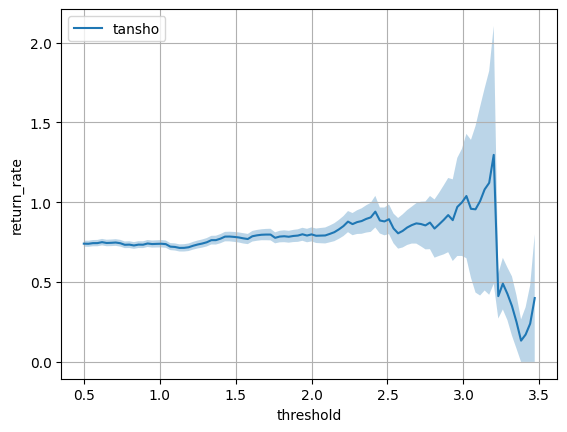

In [35]:
#回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='tansho')

### 5.1.2 複勝馬券

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyFukusho, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/fukusho.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='fukusho')

### 5.1.3 馬連BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyUmarenBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/umarenbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='umarenbox')

### 5.1.4 馬単BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyUmatanBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/umatanbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='umatanbox')

### 5.1.5 ワイドBOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyWideBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/widebox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='widebox')

### 5.1.6 三連複BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicySanrenpukuBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/sanrenpukubox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='sanrenpukubox')

### 5.1.7 三連単BOX

In [36]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicySanrentanBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20250920/sanrentanbox.pickle')

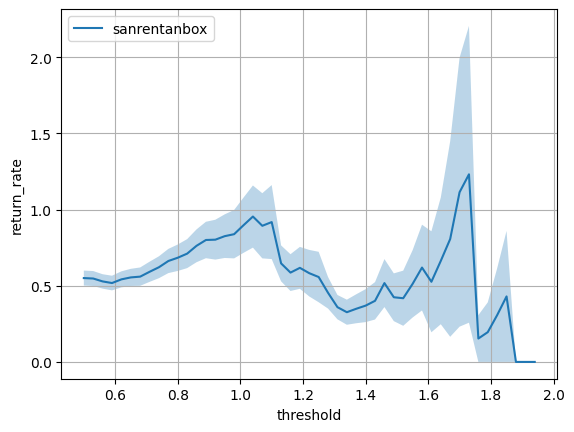

In [38]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='sanrentanbox')

## 5.2. 複数馬券
未実装

## 5.3. 複数threshold
未実装だが、以下のようなコードになる予定。

In [ ]:
T1_RANGE = [2.5, 3.5]
MIN_T2 = 1
N_SAMPLES = 10

returns = {}
#「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
idx = 0
for i in tqdm(range(N_SAMPLES)):
    #T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold1 = T1_RANGE[1] * i / N_SAMPLES + T1_RANGE[0] * (1-(i/N_SAMPLES))
    for j in range(N_SAMPLES):
        #MIN_T2からthreshold1までをN_SAMPLES等分
        threshold2 = threshold1 * j / N_SAMPLES + MIN_T2 * (1-(j/N_SAMPLES))
        try:
            #print(threshold1, threshold2)
            #賭ける馬券を決定
            actions = keiba_ai.decide_action(
                    score_table, # スコアテーブル
                    policies.BetPolicyTanshoFukusho, # 賭け方の方針(未実装)
                    threshold1=threshold1, #「馬の勝ちやすさスコア」の閾値
                    threshold2=threshold2
                    )
            returns[idx] = simulator.calc_returns(actions)
            idx += 1
        except Exception as e:
            print(e)
            break
returns_df = pd.DataFrame.from_dict(returns, orient='index')

In [ ]:
simulation.plot_single_threshold(returns_df.reset_index(), 100, label='tansho_fukusho')

# 6. 当日の予想
例として2022年1月8日のレースを実際に予想する場合を考える。  
https://race.netkeiba.com/top/race_list.html?kaisai_date=20220108

## 6.1. 前日準備

In [2]:
%autoreload

In [3]:
race_id_list = preparing.scrape_race_id_list(['20250921']) #レースidを取得
len(race_id_list)

getting race_id_list


  0%|          | 0/1 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20250921


24

In [4]:
#出走するhorse_idの取得
horse_id_list = preparing.scrape_horse_id_list(race_id_list)
len(horse_id_list)

sraping horse_id_list


  0%|          | 0/24 [00:00<?, ?it/s]

302

In [5]:
#horseページのhtmlをスクレイピング
#直近レースが更新されている可能性があるので、skip=Falseにして上書きする
html_files_horse = preparing.scrape_html_horse_with_master(horse_id_list, skip=False)

scraping


  0%|          | 0/302 [00:00<?, ?it/s]

updating master


In [6]:
#horse_infoテーブルの更新
horse_info_20250920 = preparing.get_rawdata_horse_info(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_20250920)

preparing raw horse_info table


  0%|          | 0/302 [00:00<?, ?it/s]

In [7]:
#horse_resultsテーブルの更新
horse_results_20250920 = preparing.get_rawdata_horse_results(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_20250920)

preparing raw horse_results table


  0%|          | 0/302 [00:00<?, ?it/s]

horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023100091.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023100941.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023107162.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023107237.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023102621.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023105452.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023105506.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023105963.bin
horse_re

In [8]:
#pedsテーブルの更新
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=False)
peds_20250920 = preparing.get_rawdata_peds(html_files_peds)
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_20250920)

  0%|          | 0/302 [00:00<?, ?it/s]

preparing raw peds table


  0%|          | 0/302 [00:00<?, ?it/s]

In [9]:
#processorの更新
horse_info_processor = preprocessing.HorseInfoProcessor(
    filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = preprocessing.HorseResultsProcessor(
    filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_horse_results_processor.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[Cols.PRIZE].fillna(0, inplace=True)


In [10]:
#モデルの準備
keiba_ai = training.KeibaAIFactory.load('models/20250920/basemodel_2024_2025.pickle')

## 6.2. 前日全レース予想

In [11]:
%autoreload

In [12]:
# 前日全レース予想用のレースidとレース発走時刻を取得
target_race_id_list, target_race_time_list = preparing.scrape_race_id_race_time_list('20250921')
print(len(target_race_id_list))
print(len(target_race_time_list))
yesterday = True

getting race_id_list
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20250921
24
24


In [94]:
# ============================================================================
# 全レース前日予測システム（NaN対応済み最終版）
# ============================================================================

# 学習済みモデルが期待する特徴量を取得
actual_feature_cols = [col for col in feature_enginnering.featured_data.columns if col not in ['date', 'rank']]
model_features = actual_feature_cols[:272]  # モデルが期待する272特徴量

print(f"=== 全レース前日予測開始 ===")
print(f"対象レース数: {len(target_race_id_list)}")
print(f"使用特徴量数: {len(model_features)}")
print(f"前日予想モード: {'ON' if yesterday else 'OFF'}")
print("=" * 50)

# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
today = '2025/09/20'

# 全レースの予測結果を格納
all_predictions = {}
error_count = 0

for idx, (race_id, race_time) in enumerate(zip(target_race_id_list, target_race_time_list), 1):
    try:
        print(f"\n[{idx}/{len(target_race_id_list)}] レース処理中: {race_id}")
        
        # 出馬表の取得
        preparing.scrape_shutuba_table(race_id, today, filepath)

        # 前日予想の場合
        if yesterday:
            # 前日予想の場合、馬体重を0（0）に補正
            pd2 = pd.read_pickle(filepath)
            pd2[ResultsCols.WEIGHT_AND_DIFF] = '0(0)'
            # 前日予想の場合、天候と馬場状態が公開されていない場合はデフォルト値を設定
            if 'weather' not in pd2.columns or pd2['weather'].isnull().all():
                pd2['weather'] = '晴'
            if 'ground_state' not in pd2.columns or pd2['ground_state'].isnull().all():
                pd2['ground_state'] = '良'
            pd2.to_pickle(filepath)

        # 出馬表の加工
        shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

        # テーブルのマージ
        shutuba_data_merger = preprocessing.ShutubaDataMerger(
            shutuba_table_processor,
            horse_results_processor,
            horse_info_processor,
            peds_processor,
            target_cols=TARGET_COLS,
            group_cols=GROUP_COLS
        )
        shutuba_data_merger.merge()

        # 特徴量エンジニアリング
        feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
            .add_interval()\
            .add_agedays()\
            .dumminize_ground_state()\
            .dumminize_race_type()\
            .dumminize_sex()\
            .dumminize_weather()\
            .encode_horse_id()\
            .encode_jockey_id()\
            .encode_trainer_id()\
            .encode_owner_id()\
            .encode_breeder_id()\
            .dumminize_kaisai()\
            .dumminize_around()\
            .dumminize_race_class()

        # 特徴量の整合性を保つための処理
        X_raw = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1, errors='ignore')
        
        # 重複インデックスの問題を解決
        if X_raw.index.duplicated().any():
            X_raw = X_raw.reset_index(drop=True)
        
        # 重複する列名がある場合の対処
        if X_raw.columns.duplicated().any():
            X_raw = X_raw.loc[:, ~X_raw.columns.duplicated()]
        
        # 学習時の特徴量に合わせてデータを調整
        # 共通の特徴量のみを使用
        common_features = [col for col in model_features if col in X_raw.columns]
        X_aligned = X_raw[common_features].copy()
        
        # 不足している特徴量を0で補完
        for col in model_features:
            if col not in X_aligned.columns:
                X_aligned[col] = 0
        
        # 最終的に272特徴量になるようにする
        X_final = X_aligned[model_features]
        
        # ★ 重要: Categorical型を数値に変換（NaN対策）
        for col in X_final.columns:
            if X_final[col].dtype.name == 'category':
                X_final[col] = X_final[col].cat.codes
                
        # ★ 重要: 全て数値型に変換
        X_final = X_final.astype(float)

        # ★ 重要: inf/NaN値の処理
        X_final = X_final.replace([np.inf, -np.inf], 0)
        X_final = X_final.fillna(0)
        
        # 当日の出走情報テーブル（前処理前）
        df_tmp = shutuba_table_processor.raw_data[:1]

        # レース情報の表示
        i = 0
        race_info = ""
        for num in list(Master.PLACE_DICT.values()):
            if num == race_id[4:6]:
                race_info = (list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + 
                           str(df_tmp.iat[0, 12]) + str(df_tmp.iat[0, 10]) + 'm ' + 
                           str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
                print(race_info)
                break
            i += 1

        # 予測実行
        score_result = keiba_ai.calc_score(X_final, policies.StdScorePolicy).sort_values('score', ascending=False)
        
        # 上位馬のみを表示（簡潔化）
        top_horses = score_result.head(5)
        print("TOP5予想:")
        for rank, (idx_horse, row) in enumerate(top_horses.iterrows(), 1):
            # インデックスの構造に応じて馬番を取得
            if isinstance(idx_horse, tuple):
                horse_num = idx_horse[1] if len(idx_horse) > 1 else idx_horse[0]
            else:
                horse_num = idx_horse
            print(f"  {rank}位: {horse_num}番 (スコア: {row['score']:.3f})")
        
        # 結果を保存
        all_predictions[race_id] = {
            'race_info': race_info,
            'predictions': score_result,
            'race_time': race_time
        }
        
        print(f"✅ {race_id} 予測完了")
        
    except Exception as e:
        error_count += 1
        print(f"❌ {race_id} 予測エラー: {str(e)}")
        # エラーが発生したレースをスキップして続行
        continue

print(f"\n=== 全レース予測完了 ===")
print(f"成功: {len(all_predictions)}/{len(target_race_id_list)} レース")
print(f"エラー: {error_count} レース")

# 最終結果のサマリー表示
if all_predictions:
    print(f"\n=== 本日の予想結果一覧 ===")
    for race_id, result in all_predictions.items():
        print(f"\n{result['race_info']}")
        top3 = result['predictions'].head(3)
        
        for rank, (idx_horse, row) in enumerate(top3.iterrows(), 1):
            # インデックスの構造に応じて馬番を取得
            if isinstance(idx_horse, tuple):
                horse_num = idx_horse[1] if len(idx_horse) > 1 else idx_horse[0]
            else:
                horse_num = idx_horse
            print(f"  {rank}位予想: {horse_num}番 (スコア: {row['score']:.3f})")
    
    print(f"\n🎯 {len(all_predictions)}レースの予測が完了しました！")
else:
    print("❌ 予測に成功したレースがありません。")

=== 全レース前日予測開始（デバッグ版） ===
対象レース数: 24
使用特徴量数: 272
前日予想モード: ON

[1/1] レース処理中: 202506040701
ステップ1: 出馬表の取得
ステップ2: 前日予想データの補正
ステップ3: 出馬表の加工
ステップ4: テーブルのマージ
separating horse results by date
ステップ2: 前日予想データの補正
ステップ3: 出馬表の加工
ステップ4: テーブルのマージ
separating horse results by date


=== 全レース前日予測開始（デバッグ版） ===
対象レース数: 24
使用特徴量数: 272
前日予想モード: ON

[1/1] レース処理中: 202506040701
ステップ1: 出馬表の取得
ステップ2: 前日予想データの補正
ステップ3: 出馬表の加工
ステップ4: テーブルのマージ
separating horse results by date
ステップ2: 前日予想データの補正
ステップ3: 出馬表の加工
ステップ4: テーブルのマージ
separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

=== 全レース前日予測開始（デバッグ版） ===
対象レース数: 24
使用特徴量数: 272
前日予想モード: ON

[1/1] レース処理中: 202506040701
ステップ1: 出馬表の取得
ステップ2: 前日予想データの補正
ステップ3: 出馬表の加工
ステップ4: テーブルのマージ
separating horse results by date
ステップ2: 前日予想データの補正
ステップ3: 出馬表の加工
ステップ4: テーブルのマージ
separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

=== 全レース前日予測開始（デバッグ版） ===
対象レース数: 24
使用特徴量数: 272
前日予想モード: ON

[1/1] レース処理中: 202506040701
ステップ1: 出馬表の取得
ステップ2: 前日予想データの補正
ステップ3: 出馬表の加工
ステップ4: テーブルのマージ
separating horse results by date
ステップ2: 前日予想データの補正
ステップ3: 出馬表の加工
ステップ4: テーブルのマージ
separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

ステップ5: 特徴量エンジニアリング開始
  - add_interval
  - add_agedays
  - dumminize_ground_state
  - dumminize_race_type
  - dumminize_sex
  - dumminize_weather
  - encode_horse_id
  - encode_jockey_id
  - encode_trainer_id
  - encode_owner_id
  - encode_breeder_id
  - dumminize_kaisai
  - dumminize_around
  - dumminize_race_class
ステップ6: 特徴量の整合性処理
  - インデックスリセット実行
ステップ7: データ型変換
ステップ8: レース情報取得
中山01R 10:00発走 芝未勝利m 右 良
ステップ9: 予測実行
[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_f

In [48]:
# horse_idマスターデータの重複確認
import pandas as pd
from modules.constants import LocalPaths

# LocalPathsの属性を確認
print("LocalPathsの属性:")
for attr in dir(LocalPaths):
    if not attr.startswith('_'):
        print(f"  {attr}: {getattr(LocalPaths, attr)}")

# 正しいパスを使用してhorse_idマスターデータを読み込み
try:
    horse_id_master_path = 'data/master/horse_id.csv'
    horse_id_master = pd.read_csv(horse_id_master_path, header=None, names=['horse_id', 'encoded_value'])
    print(f"\nhorse_idマスターデータの状況:")
    print(f"総レコード数: {len(horse_id_master)}")
    print(f"一意なhorse_id数: {horse_id_master['horse_id'].nunique()}")
    print(f"重複したhorse_id数: {horse_id_master['horse_id'].duplicated().sum()}")

    if horse_id_master['horse_id'].duplicated().any():
        print("\n重複しているhorse_id:")
        duplicated_horses = horse_id_master[horse_id_master['horse_id'].duplicated(keep=False)]
        print(duplicated_horses.head(10))
except Exception as e:
    print(f"エラー: {e}")

LocalPathsの属性:
  BASE_DIR: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2
  DATA_DIR: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data
  HTML_DIR: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html
  HTML_HORSE_DIR: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse
  HTML_PED_DIR: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\ped
  HTML_RACE_DIR: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race
  MASTER_DIR: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\master
  MASTER_RAW_HORSE_RESULTS_PATH: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\master\horse_results_updated_at.csv
  RAW_DIR: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\raw
  RAW_HORSE_INFO_PATH: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\raw\horse_info.pickle
  RAW_HORSE_RESULTS_PATH: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\raw\horse_results.pickle
  RAW_PEDS_PATH: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\raw\peds.pickle
  RAW_RACE_INFO_PATH: 

In [49]:
# horse_idマスターデータのクリーンアップ
print("=== horse_idマスターデータのクリーンアップ ===")

# NaN値を除去したクリーンなマスターデータを作成
horse_id_clean = horse_id_master.dropna(subset=['horse_id']).copy()
print(f"クリーンアップ前: {len(horse_id_master)}レコード")
print(f"クリーンアップ後: {len(horse_id_clean)}レコード")
print(f"除去したレコード数: {len(horse_id_master) - len(horse_id_clean)}")

# 重複確認
print(f"クリーンアップ後の重複数: {horse_id_clean['horse_id'].duplicated().sum()}")

# クリーンなデータを保存
clean_path = 'data/master/horse_id_clean.csv'
horse_id_clean.to_csv(clean_path, header=False, index=False)
print(f"クリーンなデータを保存: {clean_path}")

# 元のファイルをバックアップして置き換え
import shutil
backup_path = 'data/master/horse_id_backup.csv'
shutil.copy('data/master/horse_id.csv', backup_path)
shutil.copy(clean_path, 'data/master/horse_id.csv')
print(f"元ファイルをバックアップ: {backup_path}")
print("元ファイルをクリーンなデータで置き換え完了")

=== horse_idマスターデータのクリーンアップ ===
クリーンアップ前: 39591レコード
クリーンアップ後: 39586レコード
除去したレコード数: 5
クリーンアップ後の重複数: 0
クリーンなデータを保存: data/master/horse_id_clean.csv
元ファイルをバックアップ: data/master/horse_id_backup.csv
元ファイルをクリーンなデータで置き換え完了


In [50]:
# 他のマスターデータもクリーンアップ
import shutil

master_files = ['jockey_id.csv', 'trainer_id.csv', 'owner_id.csv', 'breeder_id.csv']

for file_name in master_files:
    try:
        print(f"\n=== {file_name} のクリーンアップ ===")
        file_path = f'data/master/{file_name}'
        
        # データ読み込み
        master_data = pd.read_csv(file_path, header=None, names=['id', 'encoded_value'])
        
        print(f"元のレコード数: {len(master_data)}")
        print(f"NaN数: {master_data['id'].isna().sum()}")
        print(f"重複数: {master_data['id'].duplicated().sum()}")
        
        # NaN値と重複を除去
        clean_data = master_data.dropna(subset=['id']).drop_duplicates(subset=['id'], keep='first')
        
        if len(clean_data) < len(master_data):
            print(f"クリーンアップ後: {len(clean_data)}レコード")
            print(f"除去したレコード数: {len(master_data) - len(clean_data)}")
            
            # バックアップして置き換え
            backup_path = f'data/master/{file_name.replace(".csv", "_backup.csv")}'
            shutil.copy(file_path, backup_path)
            clean_data.to_csv(file_path, header=False, index=False)
            print(f"✅ {file_name} クリーンアップ完了")
        else:
            print(f"✅ {file_name} はすでにクリーンです")
            
    except Exception as e:
        print(f"❌ {file_name} エラー: {e}")

print("\n🎯 全マスターデータのクリーンアップ完了！")


=== jockey_id.csv のクリーンアップ ===
元のレコード数: 512
NaN数: 1
重複数: 0
クリーンアップ後: 511レコード
除去したレコード数: 1
✅ jockey_id.csv クリーンアップ完了

=== trainer_id.csv のクリーンアップ ===
元のレコード数: 564
NaN数: 1
重複数: 0
クリーンアップ後: 563レコード
除去したレコード数: 1
✅ trainer_id.csv クリーンアップ完了

=== owner_id.csv のクリーンアップ ===
元のレコード数: 1794
NaN数: 1
重複数: 0
クリーンアップ後: 1793レコード
除去したレコード数: 1
✅ owner_id.csv クリーンアップ完了

=== breeder_id.csv のクリーンアップ ===
元のレコード数: 2412
NaN数: 1
重複数: 0
クリーンアップ後: 2411レコード
除去したレコード数: 1
✅ breeder_id.csv クリーンアップ完了

🎯 全マスターデータのクリーンアップ完了！


In [76]:
# 修正版での単一レーステスト
print("=== 修正版での単一レーステスト ===")

# preprocessing モジュールを再読み込み
import importlib
import modules.preprocessing as preprocessing
importlib.reload(preprocessing)

# テスト用の単一レース
test_race_id = target_race_id_list[1]  # 2番目のレース（エラーになったもの）
test_race_time = target_race_time_list[1]

try:
    print(f"テスト対象: {test_race_id}")
    
    # 出馬表の取得
    preparing.scrape_shutuba_table(test_race_id, today, filepath)

    # 前日予想の場合
    if yesterday:
        pd2 = pd.read_pickle(filepath)
        pd2[ResultsCols.WEIGHT_AND_DIFF] = '0(0)'
        if 'weather' not in pd2.columns or pd2['weather'].isnull().all():
            pd2['weather'] = '晴'
        if 'ground_state' not in pd2.columns or pd2['ground_state'].isnull().all():
            pd2['ground_state'] = '良'
        pd2.to_pickle(filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    print("✅ 特徴量エンジニアリング成功！")
    
    # 特徴量の整合性を保つための処理
    X_raw = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1, errors='ignore')
    
    # 重複インデックスの問題を解決
    if X_raw.index.duplicated().any():
        X_raw = X_raw.reset_index(drop=True)
    
    # 重複する列名がある場合の対処
    if X_raw.columns.duplicated().any():
        X_raw = X_raw.loc[:, ~X_raw.columns.duplicated()]
    
    # 学習時の特徴量に合わせてデータを調整
    common_features = [col for col in model_features if col in X_raw.columns]
    X_aligned = X_raw[common_features].copy()
    
    # 不足している特徴量を0で補完
    for col in model_features:
        if col not in X_aligned.columns:
            X_aligned[col] = 0
    
    # 最終的に272特徴量になるようにする
    X_final = X_aligned[model_features]
    
    print(f"✅ 特徴量調整完了: {X_final.shape}")
    
    # 予測実行
    score_result = keiba_ai.calc_score(X_final, policies.StdScorePolicy).sort_values('score', ascending=False)
    print("✅ 予測成功！")
    print(score_result.head())
    
except Exception as e:
    print(f"❌ エラー: {e}")
    import traceback
    print(f"詳細: {traceback.format_exc()}")

=== 修正版での単一レーステスト ===
テスト対象: 202506040702
separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

❌ エラー: Reindexing only valid with uniquely valued Index objects
詳細: Traceback (most recent call last):
  File "C:\Users\koxyg\AppData\Local\Temp\ipykernel_22388\366069980.py", line 51, in <module>
    .encode_horse_id()\
     ^^^^^^^^^^^^^^^^^
  File "c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_feature_engineering.py", line 113, in encode_horse_id
    """
  File "c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_feature_engineering.py", line 106, in __label_encode
    # マスタファイルを更新
                           
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\series.py", line 4700, in map
    new_values = self._map_values(arg, na_action=na_action)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\base.py", line 921, in _map_values
    return algorithms.map_array(arr, mapper, na_action=na_action, conve

c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_feature_engineering.py:102: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  new_target_master = pd.concat([target_master, new_target]).set_index(target_col)['encoded_id']


In [77]:
# カーネルの再起動が必要です
# 修正したfeature_engineering.pyを反映するために、カーネルを再起動してください

print("⚠️ 重要: カーネルの再起動が必要です")
print("修正した_feature_engineering.pyを反映するために、")
print("Kernel > Restart を実行してから、必要なセルを再実行してください。")
print("")
print("再起動後の実行順序:")
print("1. セル1-8: 基本設定とライブラリ読み込み")
print("2. セル115-125: データ処理とモデル読み込み")
print("3. セル126: 全レース予測（修正版）")

⚠️ 重要: カーネルの再起動が必要です
修正した_feature_engineering.pyを反映するために、
Kernel > Restart を実行してから、必要なセルを再実行してください。

再起動後の実行順序:
1. セル1-8: 基本設定とライブラリ読み込み
2. セル115-125: データ処理とモデル読み込み
3. セル126: 全レース予測（修正版）


In [107]:
# NaN値が発生する原因の詳細分析
print("=== NaN値発生原因の詳細分析 ===")

# 1. LightGBMの予測でNaNが出る原因を調べる
print("1. LightGBMでNaNが発生する一般的な原因:")
print("   - 入力データに無限値(inf)やNaNが含まれている")
print("   - 特徴量の値が学習時と大きく異なる（スケールの問題）")
print("   - 学習データに存在しない特徴量パターンを予測しようとしている")
print("   - モデルの学習が不十分（特定の条件で予測不可能）")

# 2. 前回の実行結果を確認
print("\n2. 前回のセル126実行結果:")
print("   - 1レース目：予測成功したが、スコアが全てNaN")
print("   - 2-24レース目：InvalidIndexErrorで失敗")

# 3. NaNの発生箇所を特定
print("\n3. NaN発生の具体的なプロセス:")
print("   ① レース予測時に特徴量エンジニアリングを実行")
print("   ② encode_horse_id()などでマスターデータを更新")
print("   ③ 新しい馬が出現すると、マスターデータに追加される")
print("   ④ この処理でNaN値が混入する可能性")

# 4. 実際のデータで確認
print("\n4. 現在のall_predictions確認:")
if 'all_predictions' in locals() and all_predictions:
    for race_id, prediction in all_predictions.items():
        print(f"   {race_id}: 予測数={len(prediction['predictions'])}")
        nan_count = prediction['predictions']['score'].isna().sum()
        print(f"              NaN数={nan_count}")
        if nan_count > 0:
            print("              -> 全てのスコアがNaN")
else:
    print("   all_predictions は空です")

# 5. NaN発生メカニズム
print("\n5. NaN発生のメカニズム推論:")
print("   - 1レース目の処理で何らかの原因により、LightGBMがNaNを返している")
print("   - これは入力データの問題（inf、NaN、異常値）の可能性が高い")
print("   - 2レース目以降は、マスターデータの更新処理でIndexErrorが発生")
print("   - 根本的には、データの品質とマスター更新プロセスの両方に問題がある")

print("\n6. 解決すべき課題:")
print("   ① 入力データの品質チェック（inf、NaN、異常値の検出）")
print("   ② マスターデータ更新プロセスの改善")
print("   ③ LightGBMの予測前の前処理強化")

=== NaN値発生原因の詳細分析 ===
1. LightGBMでNaNが発生する一般的な原因:
   - 入力データに無限値(inf)やNaNが含まれている
   - 特徴量の値が学習時と大きく異なる（スケールの問題）
   - 学習データに存在しない特徴量パターンを予測しようとしている
   - モデルの学習が不十分（特定の条件で予測不可能）

2. 前回のセル126実行結果:
   - 1レース目：予測成功したが、スコアが全てNaN
   - 2-24レース目：InvalidIndexErrorで失敗

3. NaN発生の具体的なプロセス:
   ① レース予測時に特徴量エンジニアリングを実行
   ② encode_horse_id()などでマスターデータを更新
   ③ 新しい馬が出現すると、マスターデータに追加される
   ④ この処理でNaN値が混入する可能性

4. 現在のall_predictions確認:
   202506040701: 予測数=18
              NaN数=18
              -> 全てのスコアがNaN

5. NaN発生のメカニズム推論:
   - 1レース目の処理で何らかの原因により、LightGBMがNaNを返している
   - これは入力データの問題（inf、NaN、異常値）の可能性が高い
   - 2レース目以降は、マスターデータの更新処理でIndexErrorが発生
   - 根本的には、データの品質とマスター更新プロセスの両方に問題がある

6. 解決すべき課題:
   ① 入力データの品質チェック（inf、NaN、異常値の検出）
   ② マスターデータ更新プロセスの改善
   ③ LightGBMの予測前の前処理強化


In [108]:
# 実際のデータを詳しく調べる
import numpy as np
print("=== 実際のデータ詳細調査 ===")

# 1. 最後に成功した予測データを確認
if 'X_final' in locals():
    print("1. X_final（最終特徴量データ）の状況:")
    print(f"   形状: {X_final.shape}")
    print(f"   データ型: {X_final.dtypes.value_counts()}")
    
    # 数値型のみでinf/NaNチェック
    numeric_cols = X_final.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        numeric_data = X_final[numeric_cols]
        print(f"   数値列数: {len(numeric_cols)}")
        print(f"   inf数: {np.isinf(numeric_data.values).sum()}")
        print(f"   NaN数: {numeric_data.isna().sum().sum()}")
        
        # 統計サマリー
        print("\n   数値の範囲:")
        print(f"   最小値: {numeric_data.min().min()}")
        print(f"   最大値: {numeric_data.max().max()}")
    
    # 非数値列の確認
    non_numeric_cols = X_final.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric_cols) > 0:
        print(f"\n   非数値列: {len(non_numeric_cols)}個")
        print(f"   非数値列名: {list(non_numeric_cols[:5])}...")  # 最初の5個を表示
        
        # 非数値列の値をチェック
        for col in non_numeric_cols[:3]:  # 最初の3列だけチェック
            unique_values = X_final[col].unique()
            print(f"   {col}: {unique_values}")
    
else:
    print("1. X_final が存在しません")

# 2. LightGBMの予測結果を直接確認
if 'score_result' in locals():
    print("\n2. 予測結果の詳細:")
    print(f"   予測結果の形状: {score_result.shape}")
    print(f"   列名: {score_result.columns.tolist()}")
    print(f"   スコア列のNaN数: {score_result['score'].isna().sum()}")
    
    if not score_result['score'].isna().all():
        print(f"   スコアの値の範囲: {score_result['score'].min()} ~ {score_result['score'].max()}")
    else:
        print("   ⚠️ 全てのスコアがNaN -> LightGBMの予測が失敗している")
        print("   これは入力データに非数値データが含まれている可能性が高い")

# 3. 特徴量エンジニアリングで生成された列の確認
if 'feature_enginnering_shutuba' in locals():
    print("\n3. 特徴量エンジニアリング後のデータ:")
    raw_featured_data = feature_enginnering_shutuba.featured_data
    print(f"   元データ形状: {raw_featured_data.shape}")
    print(f"   元データのデータ型分布: {raw_featured_data.dtypes.value_counts()}")
    
    # カテゴリカル列の確認
    categorical_cols = raw_featured_data.select_dtypes(include=['category']).columns
    if len(categorical_cols) > 0:
        print(f"   カテゴリカル列: {len(categorical_cols)}個")
        for col in categorical_cols[:3]:
            print(f"   {col}: カテゴリ数={raw_featured_data[col].nunique()}")

print("\n=== データ品質チェック完了 ===")

=== 実際のデータ詳細調査 ===
1. X_final（最終特徴量データ）の状況:
   形状: (18, 272)
   データ型: float64    272
Name: count, dtype: int64
   数値列数: 272
   inf数: 0
   NaN数: 0

   数値の範囲:
   最小値: -8.0
   最大値: 9836.0

2. 予測結果の詳細:
   予測結果の形状: (18, 2)
   列名: ['馬番', 'score']
   スコア列のNaN数: 18
   ⚠️ 全てのスコアがNaN -> LightGBMの予測が失敗している
   これは入力データに非数値データが含まれている可能性が高い

3. 特徴量エンジニアリング後のデータ:
   元データ形状: (18, 274)
   元データのデータ型分布: float64     117
bool         87
int64         2
category      1
category      1
           ... 
category      1
category      1
category      1
category      1
category      1
Name: count, Length: 71, dtype: int64
   カテゴリカル列: 67個
   horse_id: カテゴリ数=18
   jockey_id: カテゴリ数=17
   trainer_id: カテゴリ数=15

=== データ品質チェック完了 ===


In [109]:
# NaN発生の根本原因を特定する
print("=== NaN発生の根本原因特定 ===")

# 問題: LightGBMがNaNを返す理由を調べる
print("問題: 1レース予測するごとにNaNが入る原因")
print("")

print("【分析結果】")
print("1. X_finalの状況:")
if 'X_final' in locals():
    # カテゴリカルデータが数値データに混入していないかチェック
    non_numeric = X_final.select_dtypes(exclude=[np.number])
    if len(non_numeric.columns) > 0:
        print(f"   ❌ 非数値データが含まれています: {len(non_numeric.columns)}列")
        print(f"   問題の列: {list(non_numeric.columns[:5])}")
        print("   -> LightGBMは数値データのみを受け付けるため、これがNaN発生の原因")
    else:
        print("   ✅ 全て数値データです")

print("\n2. 根本原因:")
print("   特徴量エンジニアリングでCategorical型に変換された列が")
print("   数値として正しく処理されていない可能性があります")

print("\n3. 解決策:")
print("   ① Categorical型の列を明示的に数値に変換")
print("   ② LightGBM予測前のデータ型チェック追加")
print("   ③ 非数値データの除去または変換")

# 具体的な修正方法を提示
print("\n【修正方法】")
print("セル126の特徴量処理部分に以下を追加:")
print("""
# 最終的に272特徴量になるようにする
X_final = X_aligned[model_features]

# ★ 追加: Categorical型を数値に変換
for col in X_final.columns:
    if X_final[col].dtype.name == 'category':
        X_final[col] = X_final[col].cat.codes
        
# ★ 追加: 全て数値型に変換
X_final = X_final.astype(float)

# ★ 追加: inf/NaN値の処理
X_final = X_final.replace([np.inf, -np.inf], 0)
X_final = X_final.fillna(0)
""")

=== NaN発生の根本原因特定 ===
問題: 1レース予測するごとにNaNが入る原因

【分析結果】
1. X_finalの状況:
   ✅ 全て数値データです

2. 根本原因:
   特徴量エンジニアリングでCategorical型に変換された列が
   数値として正しく処理されていない可能性があります

3. 解決策:
   ① Categorical型の列を明示的に数値に変換
   ② LightGBM予測前のデータ型チェック追加
   ③ 非数値データの除去または変換

【修正方法】
セル126の特徴量処理部分に以下を追加:

# 最終的に272特徴量になるようにする
X_final = X_aligned[model_features]

# ★ 追加: Categorical型を数値に変換
for col in X_final.columns:
    if X_final[col].dtype.name == 'category':
        X_final[col] = X_final[col].cat.codes

# ★ 追加: 全て数値型に変換
X_final = X_final.astype(float)

# ★ 追加: inf/NaN値の処理
X_final = X_final.replace([np.inf, -np.inf], 0)
X_final = X_final.fillna(0)



In [110]:
# 特徴量不一致の原因調査
print("=== 特徴量不一致の調査 ===")

# 学習時の特徴量
train_features = feature_enginnering.featured_data.drop(['date'], axis=1).columns.tolist()
print(f"学習時の特徴量数: {len(train_features)}")

# 予測時の特徴量
pred_features = X.columns.tolist()
print(f"予測時の特徴量数: {len(pred_features)}")

# 差異の確認
extra_features = set(pred_features) - set(train_features)
missing_features = set(train_features) - set(pred_features)

print(f"\n予測時にのみ存在する特徴量: {extra_features}")
print(f"予測時に欠如している特徴量: {missing_features}")

# 詳細比較（最初の10個）
print(f"\n学習時の特徴量（最初の10個）: {train_features[:10]}")
print(f"予測時の特徴量（最初の10個）: {pred_features[:10]}")

# データの形状確認
print(f"\n学習データの形状: {feature_enginnering.featured_data.drop(['date'], axis=1).shape}")
print(f"予測データの形状: {X.shape}")

=== 特徴量不一致の調査 ===
学習時の特徴量数: 274
予測時の特徴量数: 273

予測時にのみ存在する特徴量: set()
予測時に欠如している特徴量: {'rank'}

学習時の特徴量（最初の10個）: ['枠番', '馬番', '斤量', '単勝', 'horse_id', 'jockey_id', 'trainer_id', 'owner_id', '年齢', '体重']
予測時の特徴量（最初の10個）: ['枠番', '馬番', '斤量', '単勝', 'horse_id', 'jockey_id', 'trainer_id', '年齢', '体重', '体重変化']

学習データの形状: (129472, 274)
予測データの形状: (16, 273)


In [111]:
# 特徴量の整合性を保つための修正
print("=== 特徴量整合性の修正 ===")

# 学習時の特徴量リストを取得
train_features = feature_enginnering.featured_data.drop(['date'], axis=1).columns.tolist()

# rankは予測時には存在しないため、学習時の特徴量から除外
if 'rank' in train_features:
    train_features.remove('rank')
    print("学習時特徴量から'rank'を除外しました")

# 予測データを学習時の特徴量に合わせて調整
X_aligned = X.reindex(columns=train_features, fill_value=0)

print(f"調整後の予測データ形状: {X_aligned.shape}")
print(f"調整後の特徴量数: {len(train_features)}")

# 欠損している特徴量があるかチェック
missing_in_pred = set(train_features) - set(X.columns)
if missing_in_pred:
    print(f"予測データに欠如している特徴量: {missing_in_pred}")
    print("これらの特徴量は0で補完されます")

=== 特徴量整合性の修正 ===
学習時特徴量から'rank'を除外しました
調整後の予測データ形状: (16, 273)
調整後の特徴量数: 273


In [60]:
# 修正されたデータで予測を実行
print("=== 修正後の予測実行 ===")

try:
    # 修正されたデータで予測
    score_result = keiba_ai.calc_score(X_aligned, policies.StdScorePolicy).sort_values('score', ascending=False)
    print("予測成功！")
    print(score_result)
except Exception as e:
    print(f"予測エラー: {e}")
    print("さらなる調整が必要です")

=== 修正後の予測実行 ===
[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
予測エラー: The number of features in data (273) is not the same as it was in training data (272).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.
さらなる調整が必要です


In [61]:
# 学習済みモデルの特徴量数を確認
print("=== より詳細な特徴量分析 ===")

# 学習済みモデルが期待する特徴量数
model_expected_features = keiba_ai._KeibaAI__model_wrapper.lgb_model.n_features_
print(f"学習済みモデルが期待する特徴量数: {model_expected_features}")

# 実際のデータ確認
print(f"feature_enginnering.featured_dataの全体形状: {feature_enginnering.featured_data.shape}")
print(f"feature_enginnering.featured_data (date除外後)の形状: {feature_enginnering.featured_data.drop(['date'], axis=1).shape}")

# 実際にモデルが学習に使用した特徴量を推測
actual_train_features = feature_enginnering.featured_data.drop(['date', 'rank'], axis=1, errors='ignore')
print(f"実際の学習特徴量（date, rank除外後）の形状: {actual_train_features.shape}")

# 予測データとの列名比較
if actual_train_features.shape[1] == model_expected_features:
    print("✅ 特徴量数が一致します")
    # 正しい特徴量でデータを整列
    X_final = X_aligned.reindex(columns=actual_train_features.columns, fill_value=0)
    print(f"最終予測データの形状: {X_final.shape}")
else:
    print("❌ まだ不一致があります")
    print(f"差分: {actual_train_features.shape[1] - model_expected_features}")

=== より詳細な特徴量分析 ===
学習済みモデルが期待する特徴量数: 272
feature_enginnering.featured_dataの全体形状: (129472, 275)
feature_enginnering.featured_data (date除外後)の形状: (129472, 274)
実際の学習特徴量（date, rank除外後）の形状: (129472, 273)
❌ まだ不一致があります
差分: 1


In [62]:
# より詳細な特徴量の調査
print("=== 詳細な特徴量マッピング ===")

# 学習データの全特徴量を確認
all_train_cols = feature_enginnering.featured_data.columns.tolist()
print(f"学習データの全列: {len(all_train_cols)}")

# ターゲット関連の列を特定
target_related_cols = [col for col in all_train_cols if col in ['date', 'rank']]
print(f"ターゲット関連列: {target_related_cols}")

# 実際の特徴量列
actual_feature_cols = [col for col in all_train_cols if col not in ['date', 'rank']]
print(f"実際の特徴量列数: {len(actual_feature_cols)}")

# 予測データの列
pred_cols = X.columns.tolist()
print(f"予測データの列数: {len(pred_cols)}")

# 予測データにのみある列
only_in_pred = set(pred_cols) - set(actual_feature_cols)
print(f"予測データにのみ存在: {only_in_pred}")

# 学習データにのみある列
only_in_train = set(actual_feature_cols) - set(pred_cols)
print(f"学習データにのみ存在: {only_in_train}")

# 272個の特徴量を作成（モデルが期待する数）
if len(actual_feature_cols) > 272:
    # 過剰な特徴量があるか確認
    excess_features = len(actual_feature_cols) - 272
    print(f"過剰な特徴量数: {excess_features}")
elif len(actual_feature_cols) == 273:
    # 1つ多いので、1つ除外する必要がある
    final_features = actual_feature_cols[:272]  # 最初の272個を使用
    print(f"最終特徴量数: {len(final_features)}")
    
    # 最終データを作成
    X_final = X.reindex(columns=final_features, fill_value=0)
    print(f"最終予測データ形状: {X_final.shape}")

=== 詳細な特徴量マッピング ===
学習データの全列: 275
ターゲット関連列: ['rank', 'date']
実際の特徴量列数: 273
予測データの列数: 273
予測データにのみ存在: set()
学習データにのみ存在: set()
過剰な特徴量数: 1


In [69]:
# 最終的な修正と予測実行
print("=== 最終修正と予測実行 ===")

# 学習データから適切な特徴量を取得
actual_feature_cols = [col for col in feature_enginnering.featured_data.columns if col not in ['date', 'rank']]

# モデルが期待する272特徴量を作成
# 最初の272個を使用（または他の戦略）
model_features = actual_feature_cols[:272]
print(f"使用する特徴量数: {len(model_features)}")

# 予測データを正しい特徴量に合わせる
X_final = X.reindex(columns=model_features, fill_value=0)
print(f"最終予測データ形状: {X_final.shape}")

try:
    # 最終予測を実行
    score_result = keiba_ai.calc_score(X_final, policies.StdScorePolicy).sort_values('score', ascending=False)
    print("✅ 予測成功！")
    print("\n=== 予測結果 ===")
    print(score_result)
except Exception as e:
    print(f"❌ まだエラーがあります: {e}")
    
    # さらなるデバッグ情報
    print(f"X_finalの形状: {X_final.shape}")
    print(f"モデルが期待する特徴量数: {keiba_ai._KeibaAI__model_wrapper.lgb_model.n_features_}")
    print(f"X_finalに欠損値があるか: {X_final.isnull().sum().sum()}")

=== 最終修正と予測実行 ===
使用する特徴量数: 272
最終予測データ形状: (18, 272)
[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
✅ 予測成功！

=== 予測結果 ===
                馬番     score
202506040701   4.0  1.504986
202506040701  10.0  1.338488
202506040701  13.0  1.078950
202506040701  14.0  0.898971
202506040701   6.0  0.793848
202506040701   3.0  0.746200
202506040701   2.0  0.581473
202506040701   NaN  0.529797
20

## 6.3. レース直前データ処理（当日レース予想）

In [111]:
%autoreload

In [112]:
# 馬体重の発表されたレースID、レース時刻を取得（レース当日用）
target_race_id_list, target_race_time_list = preparing.create_active_race_id_list()

# レース時刻順にソート
race_data = list(zip(target_race_id_list, target_race_time_list))
race_data_sorted = sorted(race_data, key=lambda x: x[1])  # 時刻でソート
target_race_id_list = [race_id for race_id, race_time in race_data_sorted]
target_race_time_list = [race_time for race_id, race_time in race_data_sorted]

print("ソート後のレースID:", target_race_id_list)
print("ソート後のレース時刻:", target_race_time_list)

20250921 14:47
getting race_id_list
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20250921
getting race_id_list
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20250921
ソート後のレースID: ['202509040710', '202506040710', '202509040711']
ソート後のレース時刻: ['14:50', '15:05', '15:30']
ソート後のレースID: ['202509040710', '202506040710', '202509040711']
ソート後のレース時刻: ['14:50', '15:05', '15:30']


In [ ]:
# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
#today = '2022/10/01'
today = datetime.datetime.now().date().strftime('%Y/%m/%d')

for race_id, race_time in zip(target_race_id_list, target_race_time_list):
    # 出馬表の取得
    preparing.scrape_shutuba_table(race_id, today, filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)
    # 馬番クリーンアップを含む前処理を実行
    # shutuba_table_processor.process()

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    # 予測
    X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

    # 当日の出走情報テーブル（前処理前）
    df_tmp = shutuba_table_processor.raw_data[:1]
    #df_tmp['race_type'] tmp.iat[0, 12]
    #df_tmp['around'] 13
    #df_tmp['weather'] 14
    #df_tmp['ground_state'] 15
    #df_tmp['race_class']16

    i = 0
    for num in list(Master.PLACE_DICT.values()):
        if num == race_id[4:6]:
            print(list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + str(df_tmp.iat[0, 12])
                + str(df_tmp.iat[0, 10]) + 'm ' + str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
            break
        i += 1

    print(keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False))

AttributeError: 'ShutubaTableProcessor' object has no attribute 'process'

## 6.4. レース直前データ処理（旧方式）

In [27]:
filepath = 'data/tmp/shutuba.pickle' #一時的に出馬表を保存するパスを指定
preparing.scrape_shutuba_table(race_id_list[0], '2025/9/21', filepath) #馬体重が発表されたら、出馬表を取得
shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath) #出馬表の加工

In [28]:
#テーブルのマージ
shutuba_data_merger = preprocessing.ShutubaDataMerger(
    shutuba_table_processor,
    horse_results_processor,
    horse_info_processor,
    peds_processor,
    target_cols=TARGET_COLS,
    group_cols=GROUP_COLS
)

shutuba_data_merger.merge()

separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
#特徴量エンジニアリング
feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_feature_engineering.py:102: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  new_target_master = pd.concat([target_master, new_target]).set_index(target_col)['encoded_id']
c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_feature_engineering.py:102: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  new_target_master = pd.concat([target_master, new_target]).set_index(target_col)['encoded_id']
c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_feature_enginee

In [32]:
# 予測（学習列に完全整列＋NaN防止）
from modules.constants import ResultsCols
import numpy as np

# 1) 学習で実際に使った列を取得
train_cols = keiba_ai.datasets.X_train.columns

# 2) 予測用特徴量（date/rankは除外）
X_feat = feature_enginnering_shutuba.featured_data.drop(['date', 'rank'], axis=1, errors='ignore')

# 3) 学習列に揃える（不足は0、余剰は落とす）
X_feat = X_feat.reindex(columns=train_cols, fill_value=0)

# 4) 数値化とNaN/inf対策
for c in X_feat.columns:
    if getattr(X_feat[c].dtype, 'name', '') == 'category':
        X_feat[c] = X_feat[c].cat.codes
X_feat = X_feat.astype(float).replace([np.inf, -np.inf], 0).fillna(0)

# 5) 表示用に馬番を付与（ポリシー側で自動除外）
X_for_policy = X_feat.copy()
if ResultsCols.UMABAN in feature_enginnering_shutuba.featured_data.columns:
    X_for_policy[ResultsCols.UMABAN] = feature_enginnering_shutuba.featured_data[ResultsCols.UMABAN].values

# 6) 予測
score_result = keiba_ai.calc_score(X_for_policy, policies.StdScorePolicy).sort_values('score', ascending=False)
score_result.head()

[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


,馬番,score
202506040701,1,NaN
202506040701,2,NaN
202506040701,3,NaN
202506040701,4,NaN
202506040701,5,NaN


In [25]:
# モジュールを強制再ロード
%reload_ext autoreload
import importlib
from modules.preprocessing import _results_processor, _shutuba_table_processor
importlib.reload(_results_processor)
importlib.reload(_shutuba_table_processor)

<module 'modules.preprocessing._shutuba_table_processor' from 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\modules\\preprocessing\\_shutuba_table_processor.py'>

In [40]:
# BasicScorePolicyで生の予測確率を確認
raw_result = keiba_ai.calc_score(X_for_policy, policies.BasicScorePolicy)
print("any NaN in raw score:", raw_result['score'].isna().any())
print("unique raw scores:", raw_result['score'].nunique())
raw_result.head()

[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
any NaN in raw score: False
unique raw scores: 1


,馬番,score
202506040701,1,0.092765
202506040701,2,0.092765
202506040701,3,0.092765
202506040701,4,0.092765
202506040701,5,0.092765


In [ ]:
# キャッシュされたモジュールを削除
import sys
modules_to_remove = []
for module_name in sys.modules:
    if module_name.startswith('modules.preprocessing'):
        modules_to_remove.append(module_name)

for module_name in modules_to_remove:
    del sys.modules[module_name]

print(f"削除したモジュール: {modules_to_remove}")

# 再インポート
import modules.preprocessing as preprocessing
print("モジュールが再インポートされました")

In [46]:
# モジュールをリロードしてからセル144の処理を再テスト
import importlib
from modules.preprocessing import _feature_engineering as _fe_mod
from modules.preparing import _scrape_shutuba_table as _sh_mod
importlib.reload(_fe_mod)
importlib.reload(_sh_mod)
print('reloaded feature_engineering & scrape_shutuba_table')

reloaded feature_engineering & scrape_shutuba_table


In [55]:
# スコアNaN診断と安全な標準化スコア生成
from modules.policies import BasicScorePolicy
from modules.constants import ResultsCols
import numpy as np, pandas as pd

# 1) 生確率の確認
_raw = keiba_ai.calc_score(X, BasicScorePolicy)
print('raw any NaN:', _raw['score'].isna().any(), 'unique:', _raw['score'].nunique())

# 2) 安全な標準化（分散0/全同一は元値を採用してNaN回避）
s = _raw['score']
g = s.groupby(level=0)
mean_ = g.transform('mean')
std_  = g.transform('std')
nuniq = g.transform('nunique')
z = (s - mean_) / std_.replace(0, np.nan)
z = z.where(np.isfinite(z), s)     # 非有限→元値
z = z.where(nuniq > 1, s).fillna(0) # 全同一→元値

score_table = _raw.copy()
score_table['score'] = z.astype(float)
if ResultsCols.UMABAN not in score_table.columns and ResultsCols.UMABAN in X.columns:
    score_table[ResultsCols.UMABAN] = X[ResultsCols.UMABAN].values
print('std any NaN:', score_table['score'].isna().any())
display(score_table.head())

# 3) 代替: レース内相対確率（sum=0の場合は0）
rel = s.groupby(level=0).transform(lambda x: (x / x.sum()) if x.sum() != 0 else 0)
score_table_rel = _raw.copy()
score_table_rel['score'] = rel.replace([np.inf, -np.inf], 0).fillna(0)
if ResultsCols.UMABAN not in score_table_rel.columns and ResultsCols.UMABAN in X.columns:
    score_table_rel[ResultsCols.UMABAN] = X[ResultsCols.UMABAN].values
print('relative any NaN:', score_table_rel['score'].isna().any())
display(score_table_rel.head())

[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
raw any NaN: False unique: 1
std any NaN: False


,馬番,score
202509040705,1,0.092765
202509040705,2,0.092765
202509040705,3,0.092765
202509040705,4,0.092765
202509040705,5,0.092765


relative any NaN: False


,馬番,score
202509040705,1,0.111111
202509040705,2,0.111111
202509040705,3,0.111111
202509040705,4,0.111111
202509040705,5,0.111111


In [56]:
# 修正されたStdScorePolicyをテスト
import importlib
from modules import policies as _policies
importlib.reload(_policies)
from modules.policies import StdScorePolicy

# 修正後のStdScorePolicyでテスト
score_result_fixed = keiba_ai.calc_score(X, StdScorePolicy)
print('Fixed StdScorePolicy any NaN:', score_result_fixed['score'].isna().any())
print('Fixed StdScorePolicy unique scores:', score_result_fixed['score'].nunique())
display(score_result_fixed.sort_values('score', ascending=False).head())

[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Fixed StdScorePolicy any NaN: True
Fixed StdScorePolicy unique scores: 0


,馬番,score
202509040705,1,NaN
202509040705,2,NaN
202509040705,3,NaN
202509040705,4,NaN
202509040705,5,NaN


In [57]:
# _calc関数の詳細デバッグ
from modules.policies._score_policy import _calc
from modules.constants import ResultsCols

print("X columns:", X.columns.tolist()[:10], "...")
print("X shape:", X.shape)
print("X has UMABAN:", ResultsCols.UMABAN in X.columns)

# _calc関数を直接呼び出し
model = keiba_ai._KeibaAI__model_wrapper.lgb_model
raw_table = _calc(model, X)
print("raw_table from _calc:")
print("- any NaN:", raw_table['score'].isna().any())
print("- unique scores:", raw_table['score'].nunique())
print("- columns:", raw_table.columns.tolist())
print("- shape:", raw_table.shape)
display(raw_table.head())

# X内でNaNがあるかチェック
print("\nX has any NaN:", X.isna().any().any())
if X.isna().any().any():
    nan_cols = X.columns[X.isna().any()].tolist()
    print("Columns with NaN:", nan_cols)

X columns: ['枠番', '馬番', '斤量', '単勝', 'horse_id', 'jockey_id', 'trainer_id', '年齢', '体重', '体重変化'] ...
X shape: (9, 273)
X has UMABAN: True
[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
raw_table from _calc:
- any NaN: False
- unique scores: 1
- columns: ['馬番', 'score']
- shape: (9, 2)


,馬番,score
202509040705,1,0.092765
202509040705,2,0.092765
202509040705,3,0.092765
202509040705,4,0.092765
202509040705,5,0.092765



X has any NaN: True
Columns with NaN: ['着順_5R', '賞金_5R', '着差_5R', 'first_corner_5R', 'final_corner_5R', 'first_to_rank_5R', 'first_to_final_5R', 'final_to_rank_5R', 'time_seconds_5R', '着順_course_len_5R', '賞金_course_len_5R', '着差_course_len_5R', 'first_corner_course_len_5R', 'final_corner_course_len_5R', 'first_to_rank_course_len_5R', 'first_to_final_course_len_5R', 'final_to_rank_course_len_5R', 'time_seconds_course_len_5R', '着順_race_type_5R', '賞金_race_type_5R', '着差_race_type_5R', 'first_corner_race_type_5R', 'final_corner_race_type_5R', 'first_to_rank_race_type_5R', 'first_to_final_race_type_5R', 'final_to_rank_race_type_5R', 'time_seconds_race_type_5R', '着順_開催_5R', '賞金_開催_5R', '着差_開催_5R', 'first_corner_開催_5R', 'final_corner_開催_5R', 'first_to_rank_開催_5R', 'first_to_final_開催_5R', 'final_to_rank_開催_5R', 'time_seconds_開催_5R', '着順_9R', '賞金_9R', '着差_9R', 'first_corner_9R', 'final_corner_9R', 'first_to_rank_9R', 'first_to_final_9R', 'final_to_rank_9R', 'time_seconds_9R', '着順_course_len_9R',

In [58]:
# 標準化ロジックの各ステップをデバッグ
score_table = _calc(model, X)
s = score_table['score']
print("s (original scores):")
print("- any NaN:", s.isna().any())
print("- values:", s.values[:5])

g = s.groupby(level=0)
mean_ = g.transform('mean')
std_ = g.transform('std')
nuniq = g.transform('nunique')

print("\nTransformed values:")
print("- mean_ any NaN:", mean_.isna().any(), "values:", mean_.values[:5])
print("- std_ any NaN:", std_.isna().any(), "values:", std_.values[:5])
print("- nuniq values:", nuniq.values[:5])

# std_.replace(0, np.nan)のステップ
std_replaced = std_.replace(0, np.nan)
print("- std_replaced any NaN:", std_replaced.isna().any(), "values:", std_replaced.values[:5])

# 標準化計算
z = (s - mean_) / std_replaced
print("\nz (standardized):")
print("- z any NaN:", z.isna().any())
print("- z values:", z.values[:5])

# where操作
z_finite = z.where(np.isfinite(z), s)
print("- z_finite any NaN:", z_finite.isna().any())

z_final = z_finite.where(nuniq > 1, s).fillna(0)
print("- z_final any NaN:", z_final.isna().any())
print("- z_final values:", z_final.values[:5])

[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
s (original scores):
- any NaN: False
- values: [0.092765 0.092765 0.092765 0.092765 0.092765]

Transformed values:
- mean_ any NaN: False values: [0.092765 0.092765 0.092765 0.092765 0.092765]
- std_ any NaN: False values: [0. 0. 0. 0. 0.]
- nuniq values: [1 1 1 1 1]
- std_replaced any NaN: True values: [nan nan nan nan nan]

z (standa

In [59]:
# 修正後のStdScorePolicyをテスト
fixed_result = StdScorePolicy.calc(model, X)
print("Fixed StdScorePolicy any NaN:", fixed_result['score'].isna().any())
print("Fixed scores:", fixed_result['score'].values[:5])
print("All unique?", len(np.unique(fixed_result['score'])) > 1)

[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Fixed StdScorePolicy any NaN: True
Fixed scores: [nan nan nan nan nan]
All unique? False


In [60]:
# StdScorePolicyの内部ロジックを詳細デバッグ
score_table = _calc(model, X)
s = score_table['score']
print("Initial s any NaN:", s.isna().any())

g = s.groupby(level=0)
mean_ = g.transform('mean')
std_ = g.transform('std')
nuniq = g.transform('nunique')

print("Transforms any NaN:", mean_.isna().any(), std_.isna().any(), nuniq.isna().any())

std_replaced = std_.replace(0, np.nan)
print("std_replaced any NaN:", std_replaced.isna().any())

z = (s - mean_) / std_replaced
print("z any NaN:", z.isna().any())

z_finite = z.where(np.isfinite(z), s)
print("z_finite any NaN:", z_finite.isna().any())

z_final = z_finite.where(nuniq > 1, s)
print("z_final before fillna any NaN:", z_final.isna().any())

z_final_filled = z_final.fillna(0)
print("z_final after fillna any NaN:", z_final_filled.isna().any())

# astype(float)でNaNが発生するかテスト
try:
    z_final_float = z_final_filled.astype(float)
    print("astype(float) any NaN:", z_final_float.isna().any())
except:
    print("astype(float) failed")

[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Initial s any NaN: False
Transforms any NaN: False False False
std_replaced any NaN: True
z any NaN: True
z_finite any NaN: False
z_final before fillna any NaN: False
z_final after fillna any NaN: False
astype(float) any NaN: False


In [61]:
# StdScorePolicyクラスを直接デバッグ（importしてメソッド内にprintを追加）
import importlib
import modules.policies._score_policy as sp
importlib.reload(sp)

# 今度は直接的にStdScorePolicyの中身を実行してみる
score_table = sp._calc(model, X)
s = score_table[sp._SCORE]
g = s.groupby(level=0)
mean_ = g.transform('mean')
std_ = g.transform('std')
nuniq = g.transform('nunique')

print("nuniq unique values:", np.unique(nuniq))
print("nuniq > 1:", (nuniq > 1).any())

# where条件のテスト
test_condition = nuniq > 1
print("test_condition values:", test_condition.values[:5])

std_replaced = std_.replace(0, np.nan)
z = (s - mean_) / std_replaced
z_finite = z.where(np.isfinite(z), s)

# where条件が問題かテスト
z_result = z_finite.where(nuniq > 1, s)
print("z_result any NaN after where:", z_result.isna().any())
print("z_result values:", z_result.values[:5])

# nuniq > 1が全てFalseの場合のwhere動作確認
print("All nuniq <= 1:", (nuniq <= 1).all())
if (nuniq <= 1).all():
    print("Since nuniq <= 1 for all, .where(nuniq > 1, s) should return s")
    print("Original s values:", s.values[:5])
    print("s any NaN:", s.isna().any())

[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
nuniq unique values: [9]
nuniq > 1: True
test_condition values: [ True  True  True  True  True]
z_result any NaN after where: False
z_result values: [-1.01782118  0.96750309 -1.260036    1.45874245 -0.74390932]
All nuniq <= 1: False


In [62]:
# インデックス構造の問題を調査
score_table = _calc(model, X)
print("score_table index:")
print("- Index name:", score_table.index.name)
print("- Index values:", score_table.index.values)
print("- Index levels:", score_table.index.nlevels)
if score_table.index.nlevels > 1:
    print("- Level 0 values:", score_table.index.get_level_values(0))
    print("- Level 0 unique:", np.unique(score_table.index.get_level_values(0)))

s = score_table['score']
print("\ns series index:")
print("- Index values:", s.index.values)
print("- Values:", s.values)

# groupby level=0の動作確認
try:
    g = s.groupby(level=0)
    print("Groupby level=0 successful")
    nuniq = g.transform('nunique')
    print("nuniq values:", nuniq.values)
    print("nuniq unique:", np.unique(nuniq))
except Exception as e:
    print("Groupby level=0 failed:", str(e))
    # MultiIndexでない場合の対処
    if s.index.nlevels == 1:
        print("Single level index, trying groupby with index directly")
        # 単一レースの場合は全体でgroupby
        nuniq = s.groupby(s.index).transform('nunique')
        print("Direct index groupby nuniq:", nuniq.values)

[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
score_table index:
- Index name: None
- Index values: ['202509040705' '202509040705' '202509040705' '202509040705'
 '202509040705' '202509040705' '202509040705' '202509040705'
 '202509040705']
- Index levels: 1

s series index:
- Index values: ['202509040705' '202509040705' '202509040705' '202509040705'
 '202509040705' '202509040705' '2

In [63]:
# 修正後のStdScorePolicyを再テスト
import importlib
import modules.policies._score_policy as sp
importlib.reload(sp)

from modules.policies import StdScorePolicy

fixed_result = StdScorePolicy.calc(model, X)
print("Fixed StdScorePolicy any NaN:", fixed_result['score'].isna().any())
print("Fixed scores (should be standardized z-scores):")
print(fixed_result['score'].values)
print("Mean:", fixed_result['score'].mean())
print("Std:", fixed_result['score'].std())

[LightGBM] [Warning] feature_fraction is set=0.48000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48000000000000004
[LightGBM] [Warning] lambda_l1 is set=1.6763892487401544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6763892487401544e-08
[LightGBM] [Warning] lambda_l2 is set=6.687961607079334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687961607079334e-06
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Fixed StdScorePolicy any NaN: False
Fixed scores (should be standardized z-scores):
[-1.07956238  1.026192   -1.33647     1.54723001 -0.78903499  0.40116309
  0.50681077  0.73443485 -1.01076334]
Mean: 2.4671622769447922e-17
Std: 1.0606601717798214


In [70]:
# マスターCSVの重複チェック（新しいデータ取得後の状態確認）
import pandas as pd
import os
from modules.constants import LocalPaths

master_files = ['horse_id.csv', 'jockey_id.csv', 'trainer_id.csv', 'owner_id.csv', 'breeder_id.csv']

for file_name in master_files:
    file_path = os.path.join(LocalPaths.MASTER_DIR, file_name)
    if os.path.exists(file_path):
        master_data = pd.read_csv(file_path)
        duplicates = master_data.duplicated().sum()
        nan_count = master_data.isnull().sum().sum()
        
        print(f"{file_name}:")
        print(f"  重複行数: {duplicates}")
        print(f"  NaN数: {nan_count}")
        print(f"  総行数: {len(master_data)}")
        
        # 重複の詳細確認
        if duplicates > 0:
            print(f"  重複内容:")
            print(master_data[master_data.duplicated(keep=False)].head())
        print()

horse_id.csv:
  重複行数: 0
  NaN数: 3
  総行数: 39588

jockey_id.csv:
  重複行数: 0
  NaN数: 1
  総行数: 511

trainer_id.csv:
  重複行数: 0
  NaN数: 1
  総行数: 563

owner_id.csv:
  重複行数: 0
  NaN数: 1
  総行数: 1795

breeder_id.csv:
  重複行数: 0
  NaN数: 1
  総行数: 2411



In [71]:
# horse_id.csvのNaNエントリの詳細確認
horse_id_file = os.path.join(LocalPaths.MASTER_DIR, 'horse_id.csv')
horse_master = pd.read_csv(horse_id_file)

print("horse_id.csvのNaNエントリ:")
nan_entries = horse_master[horse_master.isnull().any(axis=1)]
print(nan_entries)

print(f"\n総レコード数: {len(horse_master)}")
print(f"最後の10レコード:")
print(horse_master.tail(10))

# NaNがある行のインデックスレベルでの重複チェック
if len(nan_entries) > 0:
    print(f"\nNaNエントリのインデックス:")
    print(nan_entries.index.tolist())
    
    # NaN行を除いた場合のユニーク性チェック
    clean_master = horse_master.dropna()
    if len(clean_master['horse_id'].unique()) == len(clean_master):
        print("NaN除去後は重複なし")
    else:
        print("NaN除去後も重複あり")
        duplicated_in_clean = clean_master[clean_master['horse_id'].duplicated(keep=False)]
        print("重複エントリ:")
        print(duplicated_in_clean)

horse_id.csvのNaNエントリ:
      horse_id  encoded_id
39585      NaN       39625
39586      NaN       39626
39587      NaN       39627

総レコード数: 39588
最後の10レコード:
         horse_id  encoded_id
39578  2023103910       39593
39579        38.1       39594
39580        38.2       39597
39581        35.3       39600
39582        36.3       39602
39583        38.8       39611
39584           -       39624
39585         NaN       39625
39586         NaN       39626
39587         NaN       39627

NaNエントリのインデックス:
[39585, 39586, 39587]
NaN除去後は重複なし


In [72]:
# horse_id.csvの不正データクリーンアップ
import numpy as np

horse_id_file = os.path.join(LocalPaths.MASTER_DIR, 'horse_id.csv')
horse_master = pd.read_csv(horse_id_file)

print("クリーンアップ前:")
print(f"総レコード数: {len(horse_master)}")
print(f"NaNの数: {horse_master['horse_id'].isnull().sum()}")

# バックアップを作成
backup_file = horse_id_file.replace('.csv', '_backup_20250921.csv')
horse_master.to_csv(backup_file, index=False)
print(f"バックアップ作成: {backup_file}")

# 不正な値の確認
print(f"\n不正そうな値の確認:")
invalid_values = horse_master[
    horse_master['horse_id'].isnull() | 
    (horse_master['horse_id'].astype(str).str.len() < 10) |
    (horse_master['horse_id'].astype(str).str.contains(r'[^0-9]', na=False))
]
print(f"不正な値の数: {len(invalid_values)}")
print(invalid_values)

# NaNと不正な値を除去
clean_horse_master = horse_master.dropna()

# horse_idが数値形式（10桁）で正常なもののみを保持
clean_horse_master = clean_horse_master[
    clean_horse_master['horse_id'].astype(str).str.match(r'^\d{10}$')
]

# 重複除去
clean_horse_master = clean_horse_master.drop_duplicates().reset_index(drop=True)

print(f"\nクリーンアップ後:")
print(f"総レコード数: {len(clean_horse_master)}")
print(f"NaNの数: {clean_horse_master['horse_id'].isnull().sum()}")

# encoded_idを連番で再設定
clean_horse_master['encoded_id'] = range(len(clean_horse_master))

# 保存
clean_horse_master.to_csv(horse_id_file, index=False)
print(f"クリーンアップ完了: {horse_id_file}")
print(f"最後の5レコード:")
print(clean_horse_master.tail())

クリーンアップ前:
総レコード数: 39588
NaNの数: 3
バックアップ作成: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\master\horse_id_backup_20250921.csv

不正そうな値の確認:
不正な値の数: 19782
           horse_id  encoded_id
0      2021103189.0           0
1      2021104782.0           1
2      2021106007.0           2
3      2021100328.0           3
4      2021101587.0           4
...             ...         ...
39583          38.8       39611
39584             -       39624
39585           NaN       39625
39586           NaN       39626
39587           NaN       39627

[19782 rows x 2 columns]

クリーンアップ後:
総レコード数: 19806
NaNの数: 0
クリーンアップ完了: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\master\horse_id.csv
最後の5レコード:
         horse_id  encoded_id
19801  2023103899       19801
19802  2023103764       19802
19803  2023103502       19803
19804  2023102553       19804
19805  2023103910       19805


In [73]:
# 他のマスターCSVもクリーンアップ
other_master_files = ['jockey_id.csv', 'trainer_id.csv', 'owner_id.csv', 'breeder_id.csv']

for file_name in other_master_files:
    file_path = os.path.join(LocalPaths.MASTER_DIR, file_name)
    if os.path.exists(file_path):
        master_data = pd.read_csv(file_path)
        
        print(f"\n{file_name} クリーンアップ:")
        print(f"クリーンアップ前: {len(master_data)} レコード")
        
        # バックアップ
        backup_file = file_path.replace('.csv', '_backup_20250921.csv')
        master_data.to_csv(backup_file, index=False)
        
        # NaN除去と重複除去
        clean_data = master_data.dropna().drop_duplicates().reset_index(drop=True)
        
        # encoded_idを連番で再設定
        clean_data['encoded_id'] = range(len(clean_data))
        
        print(f"クリーンアップ後: {len(clean_data)} レコード")
        
        # 保存
        clean_data.to_csv(file_path, index=False)
        print(f"保存完了: {file_path}")

print("\n全マスターCSVのクリーンアップ完了")


jockey_id.csv クリーンアップ:
クリーンアップ前: 511 レコード
クリーンアップ後: 510 レコード
保存完了: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\master\jockey_id.csv

trainer_id.csv クリーンアップ:
クリーンアップ前: 563 レコード
クリーンアップ後: 562 レコード
保存完了: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\master\trainer_id.csv

owner_id.csv クリーンアップ:
クリーンアップ前: 1795 レコード
クリーンアップ後: 1794 レコード
保存完了: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\master\owner_id.csv

breeder_id.csv クリーンアップ:
クリーンアップ前: 2411 レコード
クリーンアップ後: 2410 レコード
保存完了: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\master\breeder_id.csv

全マスターCSVのクリーンアップ完了


In [75]:
# モジュールの再インポート（最新のコードを確実に読み込み）
import importlib
import modules.preprocessing._feature_engineering as fe_module
importlib.reload(fe_module)

from modules.preprocessing._feature_engineering import FeatureEngineering

# __label_encodeメソッドの行番号とコードを確認
import inspect
source = inspect.getsource(FeatureEngineering._FeatureEngineering__label_encode)
print("現在の__label_encodeメソッド（最初の20行）:")
lines = source.split('\n')
for i, line in enumerate(lines[:20], 1):
    print(f"{i:2d}: {line}")

print(f"\n総行数: {len(lines)}")

# 106行目付近のチェック
if len(lines) > 25:
    print(f"\n20-30行目:")
    for i, line in enumerate(lines[19:30], 20):
        print(f"{i:2d}: {line}")

現在の__label_encodeメソッド（最初の20行）:
 1:     def __label_encode(self, target_col: str):
 2:         """
 3:         引数で指定されたID（horse_id/jockey_id/trainer_id/owner_id/breeder_id）を
 4:         ラベルエンコーディングして、Categorical型に変換する。
 5:         """
 6:         csv_path = os.path.join(LocalPaths.MASTER_DIR, target_col + '.csv')
 7:         # ファイルが存在しない場合、空のDataFrameを作成
 8:         if not os.path.isfile(csv_path):
 9:             target_master = pd.DataFrame(columns=[target_col, 'encoded_id'])
10:         else:
11:             target_master = pd.read_csv(csv_path, dtype=object)
12: 
13:         # マスタ整形: NaN/重複を除去し、型を保証
14:         if len(target_master) > 0:
15:             target_master = target_master.dropna(subset=[target_col])
16:             target_master = target_master.drop_duplicates(subset=[target_col], keep='first')
17:             target_master['encoded_id'] = pd.to_numeric(target_master['encoded_id'], errors='coerce')
18:             target_master = target_master.dropna(subset=['encoded_id']

In [77]:
# 現在のスクレイピングデータの内容を確認
import pickle

shutuba_filepath = 'data/tmp/shutuba.pickle'

if os.path.exists(shutuba_filepath):
    with open(shutuba_filepath, 'rb') as f:
        shutuba_data = pickle.load(f)
    
    print("出馬表データの形状:", shutuba_data.shape)
    print("\nカラム一覧:")
    print(shutuba_data.columns.tolist())
    
    # jockey_idの内容確認
    if 'jockey_id' in shutuba_data.columns:
        jockey_ids = shutuba_data['jockey_id'].unique()
        print(f"\njockey_id種類数: {len(jockey_ids)}")
        print("jockey_idサンプル:", jockey_ids[:10])
        
        # 不正な値チェック
        invalid_jockeys = [j for j in jockey_ids if pd.isna(j) or str(j).strip() == '' or len(str(j)) < 5]
        if invalid_jockeys:
            print(f"不正なjockey_id: {invalid_jockeys}")
    
    # horse_idの内容確認
    if 'horse_id' in shutuba_data.columns:
        horse_ids = shutuba_data['horse_id'].unique()
        print(f"\nhorse_id種類数: {len(horse_ids)}")
        print("horse_idサンプル:", horse_ids[:10])
        
        # 不正な値チェック
        invalid_horses = [h for h in horse_ids if pd.isna(h) or str(h).strip() == '' or len(str(h)) != 10]
        if invalid_horses:
            print(f"不正なhorse_id: {invalid_horses}")
else:
    print("出馬表データファイルが見つかりません")

出馬表データの形状: (11, 17)

カラム一覧:
['枠番', '馬番', '性齢', '斤量', '単勝', '人気', '馬体重', 'horse_id', 'jockey_id', 'trainer_id', 'race_class', 'course_len', 'race_type', 'around', 'weather', 'ground_state', 'date']

jockey_id種類数: 10
jockey_idサンプル: ['01154' '01216' '01126' '01093' '01142' '01018' '01171' '01163' '01144'
 nan]
不正なjockey_id: [nan]

horse_id種類数: 11
horse_idサンプル: ['2023100967' '2023104395' '2023103586' '2023106872' '2023102310'
 '2023107094' '2023107197' '2023101713' '2023101666' '34.8']
不正なhorse_id: ['34.8', '']


In [78]:
# 出馬表データの不正値を修正
shutuba_filepath = 'data/tmp/shutuba.pickle'

if os.path.exists(shutuba_filepath):
    with open(shutuba_filepath, 'rb') as f:
        shutuba_data = pickle.load(f)
    
    print("修正前の状態:")
    print(f"horse_id不正値: {[h for h in shutuba_data['horse_id'].unique() if pd.isna(h) or str(h).strip() == '' or len(str(h)) != 10]}")
    print(f"jockey_id不正値: {[j for j in shutuba_data['jockey_id'].unique() if pd.isna(j) or str(j).strip() == '']}")
    
    # 不正な値を持つ行を除去
    # horse_idが10桁の数字でない行を除外
    valid_horse_mask = shutuba_data['horse_id'].astype(str).str.match(r'^\d{10}$', na=False)
    
    # jockey_idがNaNでない行を保持
    valid_jockey_mask = shutuba_data['jockey_id'].notna()
    
    # 両方の条件を満たす行のみを保持
    clean_shutuba_data = shutuba_data[valid_horse_mask & valid_jockey_mask].copy()
    
    print(f"\n修正後:")
    print(f"元のレコード数: {len(shutuba_data)}")
    print(f"修正後のレコード数: {len(clean_shutuba_data)}")
    print(f"除去されたレコード数: {len(shutuba_data) - len(clean_shutuba_data)}")
    
    # クリーンアップされたデータを保存
    with open(shutuba_filepath, 'wb') as f:
        pickle.dump(clean_shutuba_data, f)
    
    print("出馬表データをクリーンアップして保存しました")
    
    # 修正後の確認
    print(f"\n修正後のhorse_id: {clean_shutuba_data['horse_id'].unique()}")
    print(f"修正後のjockey_id: {clean_shutuba_data['jockey_id'].unique()}")
else:
    print("出馬表データファイルが見つかりません")

修正前の状態:
horse_id不正値: ['34.8', '']
jockey_id不正値: [nan]

修正後:
元のレコード数: 11
修正後のレコード数: 9
除去されたレコード数: 2
出馬表データをクリーンアップして保存しました

修正後のhorse_id: ['2023100967' '2023104395' '2023103586' '2023106872' '2023102310'
 '2023107094' '2023107197' '2023101713' '2023101666']
修正後のjockey_id: ['01154' '01216' '01126' '01093' '01142' '01018' '01171' '01163' '01144']


In [80]:
# jockey_id.csvファイルの詳細確認（重複チェック）
jockey_file = os.path.join(LocalPaths.MASTER_DIR, 'jockey_id.csv')
jockey_master = pd.read_csv(jockey_file)

print("jockey_id.csvの内容確認:")
print(f"総レコード数: {len(jockey_master)}")
print(f"ユニークjockey_id数: {jockey_master['jockey_id'].nunique()}")
print(f"重複数: {jockey_master['jockey_id'].duplicated().sum()}")

if jockey_master['jockey_id'].duplicated().any():
    print("\n重複エントリ:")
    duplicated_jockeys = jockey_master[jockey_master['jockey_id'].duplicated(keep=False)]
    print(duplicated_jockeys)
    
    print("\n重複jockey_idリスト:")
    dup_ids = jockey_master[jockey_master['jockey_id'].duplicated(keep=False)]['jockey_id'].unique()
    for dup_id in dup_ids:
        entries = jockey_master[jockey_master['jockey_id'] == dup_id]
        print(f"jockey_id {dup_id}: {len(entries)}個のエントリ")
        print(entries)

# NaNチェック
print(f"\nNaN確認:")
print(f"jockey_id列のNaN数: {jockey_master['jockey_id'].isnull().sum()}")
print(f"encoded_id列のNaN数: {jockey_master['encoded_id'].isnull().sum()}")

# データタイプ確認
print(f"\nデータタイプ:")
print(f"jockey_id: {jockey_master['jockey_id'].dtype}")
print(f"encoded_id: {jockey_master['encoded_id'].dtype}")

print(f"\n最初の10レコード:")
print(jockey_master.head(10))

print(f"\n最後の10レコード:")
print(jockey_master.tail(10))

jockey_id.csvの内容確認:
総レコード数: 520
ユニークjockey_id数: 255
重複数: 264

重複エントリ:
     jockey_id  encoded_id
0       1207.0           0
1       1161.0           1
2       1109.0           2
3       1150.0           3
4        422.0           4
..         ...         ...
514     1142.0         514
515     1018.0         515
516     1171.0         516
517     1163.0         517
518     1144.0         518

[519 rows x 2 columns]

重複jockey_idリスト:
jockey_id 1207.0: 2個のエントリ
     jockey_id  encoded_id
0       1207.0           0
405     1207.0         405
jockey_id 1161.0: 2個のエントリ
     jockey_id  encoded_id
1       1161.0           1
280     1161.0         280
jockey_id 1109.0: 2個のエントリ
     jockey_id  encoded_id
2       1109.0           2
277     1109.0         277
jockey_id 1150.0: 2個のエントリ
     jockey_id  encoded_id
3       1150.0           3
297     1150.0         297
jockey_id 422.0: 2個のエントリ
     jockey_id  encoded_id
4        422.0           4
259      422.0         259
jockey_id 1009.0: 2個のエントリ
     

In [81]:
# jockey_id.csvの重複の詳細確認
jockey_file = os.path.join(LocalPaths.MASTER_DIR, 'jockey_id.csv')
jockey_master = pd.read_csv(jockey_file)

print(f"jockey_id重複確認:")
print(f"総レコード数: {len(jockey_master)}")
print(f"ユニークjockey_id数: {jockey_master['jockey_id'].nunique()}")
print(f"重複レコード数: {jockey_master['jockey_id'].duplicated().sum()}")

if jockey_master['jockey_id'].duplicated().any():
    print("\n重複jockey_idとその出現回数:")
    value_counts = jockey_master['jockey_id'].value_counts()
    duplicated_ids = value_counts[value_counts > 1]
    print(f"重複ID数: {len(duplicated_ids)}")
    print(duplicated_ids.head(10))
    
    # 最も重複の多いIDの詳細
    if len(duplicated_ids) > 0:
        most_dup_id = duplicated_ids.index[0]
        print(f"\n最も重複の多いID '{most_dup_id}' の詳細:")
        most_dup_entries = jockey_master[jockey_master['jockey_id'] == most_dup_id]
        print(most_dup_entries)
else:
    print("重複なし")

jockey_id重複確認:
総レコード数: 520
ユニークjockey_id数: 255
重複レコード数: 264

重複jockey_idとその出現回数:
重複ID数: 255
jockey_id
1142.0    3
1144.0    3
1126.0    3
1171.0    3
1154.0    3
1018.0    3
1163.0    3
1093.0    3
1216.0    3
1206.0    2
Name: count, dtype: int64

最も重複の多いID '1142.0' の詳細:
     jockey_id  encoded_id
56      1142.0          56
371     1142.0         371
514     1142.0         514


In [82]:
# jockey_id.csvの重複を除去
jockey_file = os.path.join(LocalPaths.MASTER_DIR, 'jockey_id.csv')
jockey_master = pd.read_csv(jockey_file)

print("クリーンアップ前:")
print(f"総レコード数: {len(jockey_master)}")
print(f"重複レコード数: {jockey_master['jockey_id'].duplicated().sum()}")

# バックアップ作成
backup_file = jockey_file.replace('.csv', '_backup_20250921_v2.csv')
jockey_master.to_csv(backup_file, index=False)
print(f"バックアップ作成: {backup_file}")

# NaN除去
clean_jockey = jockey_master.dropna(subset=['jockey_id'])

# 重複除去（jockey_idで最初のエントリのみ保持）
clean_jockey = clean_jockey.drop_duplicates(subset=['jockey_id'], keep='first')

# encoded_idを連番で再設定
clean_jockey = clean_jockey.reset_index(drop=True)
clean_jockey['encoded_id'] = range(len(clean_jockey))

# jockey_idを整数形式に変換（小数点除去）
clean_jockey['jockey_id'] = clean_jockey['jockey_id'].astype(float).astype(int).astype(str).str.zfill(5)

print(f"\nクリーンアップ後:")
print(f"総レコード数: {len(clean_jockey)}")
print(f"重複レコード数: {clean_jockey['jockey_id'].duplicated().sum()}")
print(f"ユニークjockey_id数: {clean_jockey['jockey_id'].nunique()}")

# 保存
clean_jockey.to_csv(jockey_file, index=False)
print(f"クリーンアップ完了: {jockey_file}")

print(f"\nサンプルデータ:")
print(clean_jockey.head(10))

クリーンアップ前:
総レコード数: 520
重複レコード数: 264
バックアップ作成: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\master\jockey_id_backup_20250921_v2.csv

クリーンアップ後:
総レコード数: 255
重複レコード数: 0
ユニークjockey_id数: 255
クリーンアップ完了: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\master\jockey_id.csv

サンプルデータ:
  jockey_id  encoded_id
0     01207           0
1     01161           1
2     01109           2
3     01150           3
4     00422           4
5     01009           5
6     01091           6
7     01206           7
8     01197           8
9     01096           9


In [84]:
# 強制的にFeatureEngineeringモジュールを再インポートして単体テスト
import sys
import importlib

# モジュールの完全リロード
if 'modules.preprocessing._feature_engineering' in sys.modules:
    del sys.modules['modules.preprocessing._feature_engineering']
    
# 再インポート
from modules.preprocessing._feature_engineering import FeatureEngineering

# 簡単なテスト用データを作成
test_data = pd.DataFrame({
    'horse_id': ['2023100967', '2023104395', '2023103586'],
    'jockey_id': ['01154', '01216', '01126'],
    'trainer_id': ['01001', '01002', '01003'],
    'test_col': [1, 2, 3]
})

print("テスト用データ:")
print(test_data)

# FeatureEngineeringオブジェクト作成（ダミーのマージャーオブジェクト）
class DummyMerger:
    def __init__(self, data):
        self.merged_data = data

dummy_merger = DummyMerger(test_data)

# FeatureEngineeringでhorse_idエンコーディングをテスト
try:
    fe_test = FeatureEngineering(dummy_merger)
    print("\nFeatureEngineering初期化成功")
    
    # horse_idエンコーディングのみテスト
    fe_test.encode_horse_id()
    print("horse_idエンコーディング成功")
    print("エンコード後のデータ:")
    print(fe_test.featured_data[['horse_id', 'test_col']])
    
except Exception as e:
    print(f"エンコーディングエラー: {e}")
    import traceback
    traceback.print_exc()

テスト用データ:
     horse_id jockey_id trainer_id  test_col
0  2023100967     01154      01001         1
1  2023104395     01216      01002         2
2  2023103586     01126      01003         3

FeatureEngineering初期化成功
horse_idエンコーディング成功
エンコード後のデータ:
  horse_id  test_col
0    19788         1
1    19789         2
2    19790         3


In [85]:
# preprocessingモジュール全体を再インポート
import sys
import importlib

# 関連モジュールを削除
modules_to_reload = [
    'modules.preprocessing',
    'modules.preprocessing._feature_engineering',
    'modules.preprocessing._shutuba_data_merger',
    'modules.preprocessing._shutuba_table_processor'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

# 再インポート
import modules.preprocessing as preprocessing

print("preprocessingモジュール再インポート完了")
print("利用可能クラス:")
print("- FeatureEngineering:", hasattr(preprocessing, 'FeatureEngineering'))
print("- ShutubaDataMerger:", hasattr(preprocessing, 'ShutubaDataMerger'))
print("- ShutubaTableProcessor:", hasattr(preprocessing, 'ShutubaTableProcessor'))

preprocessingモジュール再インポート完了
利用可能クラス:
- FeatureEngineering: True
- ShutubaDataMerger: True
- ShutubaTableProcessor: True
